In [ ]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
import numpy as np
import random
import os

from sklearn.metrics import accuracy_score,log_loss,precision_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

import lightgbm as lgb
#import catboost as ctb
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz

import graphviz
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

# Dacon credit-card analysis

https://dacon.io/competitions/official/235713/overview/description/

In [ ]:
SEED = 2021
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# 1. EDA

https://3months.tistory.com/292
## (1) 데이터 불러오기

In [ ]:
train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

#전체적인 시각화와 결측치, 중복값을 보기위해 만든 함수
all_df = pd.concat([train_df, test_df]).reset_index(drop=True)


In [ ]:
print("rows and columns in train set : ", train_df.shape)
print("rows and columns in test set : ", test_df.shape)

rows and columns in train set :  (26457, 20)
rows and columns in test set :  (10000, 19)


In [ ]:
print(train_df.head(5))

   index gender car reality  ...   occyp_type  family_size begin_month credit
0      0      F   N       N  ...          NaN          2.0        -6.0    1.0
1      1      F   N       Y  ...     Laborers          3.0        -5.0    1.0
2      2      M   Y       Y  ...     Managers          2.0       -22.0    2.0
3      3      F   N       Y  ...  Sales staff          2.0       -37.0    0.0
4      4      F   Y       Y  ...     Managers          2.0       -26.0    2.0

[5 rows x 20 columns]


## (2) 데이터 변수 설명

- gender(범주) : 성별 
- car(범주) : 차량 소유 여부
- reality(범주) : 부동산 소유 여부
- child_num(범주): 자녀 수
- income_total(수치) : 연간 소득
- income_type(범주) : 소득 분류
    * 'Commercial associate' :상업 제휴
    * 'Working' : 일반 근무
    * 'State servant' : 공무원
    * 'Pensioner' : 연금 수령자
    * 'Student' : 학생
- edu_type(범주) : 교육 수준
    * 'Higher education' : 고등 교육
    * 'Secondary / secondary special' : 중등 교육?
    * 'Incomplete higher' : 고등학교 중퇴
    * 'Lower secondary'  : 중등교육 아래
    * 'Academic degree' : 학위
- family_type(범주): 결혼 여부
    * 'Married' : 결혼함.
    * 'Civil marriage' : 민사적 결혼? 법률혼
    * 'Separated' : 분리된 가족?
    * 'Single / not married' :싱글
    * 'Widow' : 과부
- house_type(범주) : 생활 방식
    * 'Municipal apartment' : 시립 아파트?LH같은거일듯.
    * 'House / apartment' : 주택/ 아파트
    * 'With parents' : 부모님 집
    * 'Co-op apartment' : 전세같음. https://mentor.heykorean.com/web/qa.php?sno=167848
    * 'Rented apartment' : 빌린 아파트?
    * 'Office apartment' : 회사 아파트
- DAYS_BIRTH(수치) : 출생일. 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미
- DAYS_EMPLOYED(수치) : 업무 시작일. 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미. 양수 값은 고용되지 않은 상태를 의미함

- FLAG_MOBIL(범주): 핸드폰 소유 여부
- work_phone(범주): 업무용 전화 소유 여부
- phone(범주): 전화 소유 여부
- email(범주): 이메일 소유 여부
- occyp_type(범주): 직업 유형
- family_size(범주): 가족 규모
- begin_month(수치): 신용카드 발급 월. 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미


- credit(범주) : 사용자의 신용카드 대금 연체를 기준으로 한 신용도. 낮을수록 높은 신용의 신용카드 사용자를 의미. 상중하(0,1,2)

https://www.dacon.io/competitions/official/235713/talkboard/402821/

## (3) 결측치 갯수 측정

In [ ]:
print('Missing values per columns in train dataset')
for col in train_df.columns:
    temp_col = train_df[col].isnull().sum()
    print(f'{col}: {temp_col}')
print()
print('Missing values per columns in test dataset')
for col in test_df.columns:
    temp_col = test_df[col].isnull().sum()
    print(f'{col}: {temp_col}')

Missing values per columns in train dataset
index: 0
gender: 0
car: 0
reality: 0
child_num: 0
income_total: 0
income_type: 0
edu_type: 0
family_type: 0
house_type: 0
DAYS_BIRTH: 0
DAYS_EMPLOYED: 0
FLAG_MOBIL: 0
work_phone: 0
phone: 0
email: 0
occyp_type: 8171
family_size: 0
begin_month: 0
credit: 0

Missing values per columns in test dataset
index: 0
gender: 0
car: 0
reality: 0
child_num: 0
income_total: 0
income_type: 0
edu_type: 0
family_type: 0
house_type: 0
DAYS_BIRTH: 0
DAYS_EMPLOYED: 0
FLAG_MOBIL: 0
work_phone: 0
phone: 0
email: 0
occyp_type: 3152
family_size: 0
begin_month: 0


In [ ]:
all_df




,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,36452,F,Y,Y,0,202500.0,Working,Incomplete higher,Married,House / apartment,-18593,-5434,1,1,1,0,Accountants,2.0,-19.0,NaN
36453,36453,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,1,0,0,Laborers,2.0,-34.0,NaN
36454,36454,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,1,0,0,0,Medicine staff,2.0,-55.0,NaN
36455,36455,F,Y,N,0,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-16541,-1085,1,0,1,0,NaN,2.0,-33.0,NaN


In [ ]:
all_df['occyp_type'] = all_df['occyp_type'].fillna('X')


In [ ]:
print(all_df['DAYS_EMPLOYED'])

0        -4709
1        -1540
2        -4434
3        -2092
4        -2105
         ...  
36452    -5434
36453    -1315
36454   -14018
36455    -1085
36456     -187
Name: DAYS_EMPLOYED, Length: 36457, dtype: int64


In [ ]:
Employ_list=all_df['DAYS_EMPLOYED'].unique().tolist()
for i in Employ_list:
    if i>=0: print(i)

365243


In [ ]:
all_df['DAYS_EMPLOYED']=all_df['DAYS_EMPLOYED'].map(lambda x:0 if (x == 365243) else x)


In [ ]:
Employ_list=all_df['DAYS_EMPLOYED'].unique().tolist()
for i in Employ_list:
    if i>=0: print(i)

0


결측치가 존재하는 데이터는 occyp_type.
DAYS_EMPLOYED는 결측치가 없어보이지만 결측치가 365243으로  대체되어있어서 0으로 바꾸어줌.

## (4) 범주형 변수 종류 확인하기



In [ ]:
train_df.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit'],
      dtype='object')

In [ ]:
category_feature=['gender', 'car', 'reality', 'child_num', 
                  'edu_type', 'family_type', 'house_type',
                  'FLAG_MOBIL', 'work_phone', 'phone', 'income_type',
                  'email','occyp_type', 'family_size', 'credit']

numeric_feature=['income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']

In [ ]:
print(category_feature)
print(numeric_feature)

['gender', 'car', 'reality', 'child_num', 'edu_type', 'family_type', 'house_type', 'FLAG_MOBIL', 'work_phone', 'phone', 'income_type', 'email', 'occyp_type', 'family_size', 'credit']
['income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']


In [ ]:
for feature in category_feature:
    print("{}'s unique feature: {}".format(feature,train_df[feature].unique()))
    print()
    

gender's unique feature: ['F' 'M']

car's unique feature: ['N' 'Y']

reality's unique feature: ['N' 'Y']

child_num's unique feature: [ 0  1  2  3  4  5 14 19  7]

edu_type's unique feature: ['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']

family_type's unique feature: ['Married' 'Civil marriage' 'Separated' 'Single / not married' 'Widow']

house_type's unique feature: ['Municipal apartment' 'House / apartment' 'With parents'
 'Co-op apartment' 'Rented apartment' 'Office apartment']

FLAG_MOBIL's unique feature: [1]

work_phone's unique feature: [0 1]

phone's unique feature: [0 1]

income_type's unique feature: ['Commercial associate' 'Working' 'State servant' 'Pensioner' 'Student']

email's unique feature: [0 1]

occyp_type's unique feature: [nan 'Laborers' 'Managers' 'Sales staff' 'High skill tech staff'
 'Core staff' 'Drivers' 'Medicine staff' 'Accountants' 'Realty agents'
 'Security staff' 'Cleaning staff' 'Private serv

https://m.blog.naver.com/PostView.nhn?blogId=cjh226&logNo=221266237919&proxyReferer=https:%2F%2Fwww.google.com%2F

### 중복 변수 체크



In [ ]:
train_df[train_df[train_df.columns.drop("index")].duplicated(keep = False)].sort_values(["DAYS_BIRTH","income_total"])

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
11314,11314,F,N,Y,0,112500.0,Pensioner,Lower secondary,Married,House / apartment,-24821,365243,1,0,0,0,NaN,2.0,-50.0,2.0
11553,11553,F,N,Y,0,112500.0,Pensioner,Lower secondary,Married,House / apartment,-24821,365243,1,0,0,0,NaN,2.0,-50.0,2.0
1441,1441,M,Y,Y,0,180000.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-24780,365243,1,0,0,0,NaN,2.0,-50.0,2.0
20250,20250,M,Y,Y,0,180000.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-24780,365243,1,0,0,0,NaN,2.0,-50.0,2.0
989,989,F,N,Y,0,90000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-24665,365243,1,0,0,0,NaN,2.0,-35.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6100,6100,M,Y,N,0,225000.0,Working,Secondary / secondary special,Single / not married,House / apartment,-8107,-985,1,0,0,0,Drivers,1.0,-24.0,2.0
9205,9205,F,N,N,0,90000.0,Commercial associate,Secondary / secondary special,Single / not married,With parents,-7757,-900,1,0,0,0,Sales staff,1.0,-13.0,1.0
25458,25458,F,N,N,0,90000.0,Commercial associate,Secondary / secondary special,Single / not married,With parents,-7757,-900,1,0,0,0,Sales staff,1.0,-13.0,1.0
20255,20255,M,N,Y,0,135000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,-7723,-366,1,0,0,1,Sales staff,1.0,0.0,1.0


In [ ]:
dup_trand_df=pd.DataFrame()
dup_df=train_df[train_df.columns.drop("index")].drop_duplicates()

dup_df

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,1,0,0,0,Core staff,4.0,-2.0,1.0
26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,NaN,2.0,-47.0,2.0
26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0
26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0,-59.0,2.0


In [ ]:
train_df[train_df[train_df.columns.drop("index",)].duplicated(keep = False)].sort_values(["DAYS_BIRTH","income_total"])

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
11314,11314,F,N,Y,0,112500.0,Pensioner,Lower secondary,Married,House / apartment,-24821,365243,1,0,0,0,NaN,2.0,-50.0,2.0
11553,11553,F,N,Y,0,112500.0,Pensioner,Lower secondary,Married,House / apartment,-24821,365243,1,0,0,0,NaN,2.0,-50.0,2.0
1441,1441,M,Y,Y,0,180000.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-24780,365243,1,0,0,0,NaN,2.0,-50.0,2.0
20250,20250,M,Y,Y,0,180000.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-24780,365243,1,0,0,0,NaN,2.0,-50.0,2.0
989,989,F,N,Y,0,90000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-24665,365243,1,0,0,0,NaN,2.0,-35.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6100,6100,M,Y,N,0,225000.0,Working,Secondary / secondary special,Single / not married,House / apartment,-8107,-985,1,0,0,0,Drivers,1.0,-24.0,2.0
9205,9205,F,N,N,0,90000.0,Commercial associate,Secondary / secondary special,Single / not married,With parents,-7757,-900,1,0,0,0,Sales staff,1.0,-13.0,1.0
25458,25458,F,N,N,0,90000.0,Commercial associate,Secondary / secondary special,Single / not married,With parents,-7757,-900,1,0,0,0,Sales staff,1.0,-13.0,1.0
20255,20255,M,N,Y,0,135000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,-7723,-366,1,0,0,1,Sales staff,1.0,0.0,1.0


In [ ]:
overlap_begin=train_df[train_df.drop(["index","begin_month"], axis = 1).duplicated(keep = False)].sort_values(["DAYS_BIRTH","income_total"])

In [ ]:
train_df[train_df.drop(["index","begin_month"], axis = 1).duplicated(keep = False)].sort_values(["DAYS_BIRTH","income_total"])

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
17245,17245,F,N,Y,0,76500.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-25140,365243,1,0,0,0,NaN,1.0,-55.0,0.0
18952,18952,F,N,Y,0,76500.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-25140,365243,1,0,0,0,NaN,1.0,-11.0,0.0
24279,24279,F,N,Y,0,76500.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-25140,365243,1,0,0,0,NaN,1.0,-49.0,0.0
17632,17632,F,N,Y,0,90000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-24970,365243,1,0,0,0,NaN,1.0,-22.0,1.0
26112,26112,F,N,Y,0,90000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-24970,365243,1,0,0,0,NaN,1.0,-34.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20609,20609,F,N,Y,1,180000.0,Working,Secondary / secondary special,Married,With parents,-8041,-1419,1,0,1,1,Sales staff,3.0,-28.0,2.0
9205,9205,F,N,N,0,90000.0,Commercial associate,Secondary / secondary special,Single / not married,With parents,-7757,-900,1,0,0,0,Sales staff,1.0,-13.0,1.0
25458,25458,F,N,N,0,90000.0,Commercial associate,Secondary / secondary special,Single / not married,With parents,-7757,-900,1,0,0,0,Sales staff,1.0,-13.0,1.0
20255,20255,M,N,Y,0,135000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,-7723,-366,1,0,0,1,Sales staff,1.0,0.0,1.0


In [ ]:
overlap_begin.groupby('credit')['credit'].value_counts()

credit  credit
0.0     0.0        2049
1.0     1.0        4390
2.0     2.0       13936
Name: credit, dtype: int64

In [ ]:
train_df[train_df.drop(["index","begin_month","credit"], axis = 1).duplicated(keep = False)].sort_values(["DAYS_BIRTH","income_total"])

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
17245,17245,F,N,Y,0,76500.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-25140,365243,1,0,0,0,NaN,1.0,-55.0,0.0
18952,18952,F,N,Y,0,76500.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-25140,365243,1,0,0,0,NaN,1.0,-11.0,0.0
24279,24279,F,N,Y,0,76500.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-25140,365243,1,0,0,0,NaN,1.0,-49.0,0.0
17632,17632,F,N,Y,0,90000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-24970,365243,1,0,0,0,NaN,1.0,-22.0,1.0
26112,26112,F,N,Y,0,90000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-24970,365243,1,0,0,0,NaN,1.0,-34.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9205,9205,F,N,N,0,90000.0,Commercial associate,Secondary / secondary special,Single / not married,With parents,-7757,-900,1,0,0,0,Sales staff,1.0,-13.0,1.0
13980,13980,F,N,N,0,90000.0,Commercial associate,Secondary / secondary special,Single / not married,With parents,-7757,-900,1,0,0,0,Sales staff,1.0,-2.0,0.0
25458,25458,F,N,N,0,90000.0,Commercial associate,Secondary / secondary special,Single / not married,With parents,-7757,-900,1,0,0,0,Sales staff,1.0,-13.0,1.0
20255,20255,M,N,Y,0,135000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,-7723,-366,1,0,0,1,Sales staff,1.0,0.0,1.0


# ENCODING 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.utils import to_categorical

import statsmodels.api as sm
import matplotlib.pyplot as plt

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
TARGET='credit'

In [ ]:
# def label_encoder(c):
#     le = LabelEncoder()
#     return le.fit_transform(c)

# def label_test_encoder(c):
#     le = LabelEncoder()
#     return le.transform(c)



scaler = StandardScaler()


In [ ]:
def Simple_lightGBM(x,y):
    X_train, X_valid, y_train, y_valid = train_test_split(x,y,test_size=0.25, random_state=21)

    eval_set = [(X_train, y_train), (X_valid, y_valid)]
    lgbm_model=lgb.LGBMClassifier(objective='multiclass',n_estimators=1000,max_depth=20,)


    lgbm_model.fit(X_train, y_train,early_stopping_rounds=100, eval_metric='logloss',eval_set=eval_set, verbose=True)

    #y_pred=lgbm_model.predict_proba(X_valid)
    #logloss=log_loss(to_categorical(y_valid), y_pred)
    #accuracy=accuracy_score(y_pred, y_test)

    y_pred=lgbm_model.predict(X_valid)

    #preds=lgbm_model.predict(X_valid)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score( y_valid, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    results = lgbm_model.evals_result_
    epochs = len(results['valid_1']['multi_logloss'])
    x_axis = range(0, epochs)
    #print("확인 : ", min(results['valid_1']['multi_logloss']))

    
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['training']['multi_logloss'], label='Train')
    ax.plot(x_axis, results['valid_1']['multi_logloss'], label='Valid')
    ax.legend()
    plt.ylabel('Log Loss')
    plt.title('LightGBM Log Loss')
    plt.show()

    # y_proba=lgbm_model.predict_proba(X_valid)
    # logloss=log_loss(to_categorical(y_valid), y_proba)
    # print(f"log_loss: {logloss}")

    logloss = min(results['valid_1']['multi_logloss'])



    #pd.DataFrame(preds).apply(lambda x: np.argmax(x), axis=1)


    #print(f"log_loss: {logloss}")
    #print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(preds,y_valid)))
    print()
    lgb.plot_importance(lgbm_model)
    return logloss


In [ ]:
def Some_lightGBM(x,y):
    X_train, X_valid, y_train, y_valid = train_test_split(x,y,test_size=0.25, random_state=21)

    eval_set = [(X_train, y_train), (X_valid, y_valid)]

    lgbm_model=lgb.LGBMClassifier(objective='multiclass',n_estimators=1000,max_depth=20,min_data_in_leaf=300)


    lgbm_model.fit(X_train, y_train,early_stopping_rounds=20, eval_metric='logloss',eval_set=eval_set, verbose=True)

    #y_pred=lgbm_model.predict_proba(X_valid)
    #logloss=log_loss(to_categorical(y_valid), y_pred)
    #accuracy=accuracy_score(y_pred, y_test)

    y_pred=lgbm_model.predict(X_valid)

    #preds=lgbm_model.predict(X_valid)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score( y_valid, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    results = lgbm_model.evals_result_
    epochs = len(results['valid_1']['multi_logloss'])
    x_axis = range(0, epochs)
    #print("확인 : ", min(results['valid_1']['multi_logloss']))

    
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['training']['multi_logloss'], label='Train')
    ax.plot(x_axis, results['valid_1']['multi_logloss'], label='Valid')
    ax.legend()
    plt.ylabel('Log Loss')
    plt.title('LightGBM Log Loss')
    plt.show()

    # y_proba=lgbm_model.predict_proba(X_valid)
    # logloss=log_loss(to_categorical(y_valid), y_proba)
    # print(f"log_loss: {logloss}")

    logloss = min(results['valid_1']['multi_logloss'])



    #pd.DataFrame(preds).apply(lambda x: np.argmax(x), axis=1)


    #print(f"log_loss: {logloss}")
    #print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(preds,y_valid)))
    print()
    lgb.plot_importance(lgbm_model)
    return logloss


In [ ]:
df_logloss={}

In [ ]:
import copy

In [ ]:
def make_temp(label_cols, numerical_cols,rf_pick=0):

    train_temp = all_df.iloc[:26457, :]#0개~100000개
    test_temp = all_df.iloc[26457:, :] #100000개~ 
    #print(test_temp)
    
    #train data 인코딩 (fit_transform)
    label_encoder= LabelEncoder()
    #scaler = StandardScaler()
    label_train_encoded_df = pd.DataFrame(columns=label_cols)
    label_test_encoded_df = pd.DataFrame(columns=label_cols)
    for i in label_cols:
      label_train_encoded_df[i]=label_encoder.fit_transform(train_temp[i])
      label_test_encoded_df[i]=label_encoder.transform(test_temp[i])


    #label_encoded_df = pd.DataFrame(label_encoder.fit_transform(train_temp[label_cols]),columns=label_cols)
    #numerical_df = pd.DataFrame(scaler.fit_transform(train_temp[numerical_cols]), columns=numerical_cols)
    numerical_df = train_temp[numerical_cols]
    target_df = train_temp[TARGET]

    train = pd.concat([numerical_df, label_train_encoded_df, target_df], axis=1)


    #test data 인코딩 (transform)

    #label_encoded_df =  pd.DataFrame(label_encoder.transform(test_temp[label_cols]))
    #numerical_df = pd.DataFrame(scaler.transform(test_temp[numerical_cols]), columns=numerical_cols)
    numerical_df = test_temp[numerical_cols].reset_index(drop=True)
    #target_df = test_temp[TARGET]

    test= pd.concat([numerical_df, label_test_encoded_df], axis=1)



    # train = temp.iloc[:26457, :]#0개~100000개
    # test = temp.iloc[26457:, :] #100000개~ 

    #iloc은 정수형 인덱싱
    #test = test.drop(TARGET, axis=1) #test에서 종속변수를 드랍한다. 
    y= train.loc[:,TARGET]
    X= train.drop(TARGET,axis=1)

    logloss=Simple_lightGBM(X,y)

    
    if rf_pick==1:
        X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.25, random_state=21)
        rf = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)
        cross_val_score(rf, X_train, y_train, cv=3)
        rf.score(X_valid, y_valid)
        print(classification_report(y_valid, rf.predict(X_valid)))

        feature_importance_rf = pd.DataFrame(zip(X.columns.values, rf.feature_importances_))
        feature_importance_rf.columns = ['feature', 'importance']
        feature_importance_rf.sort_values("importance", ascending=False, inplace=True)
        print(feature_importance_rf)
        
    
    return train,test,logloss
    

In [ ]:
def tun_make_temp(label_cols, numerical_cols,rf_pick=0):

    train_temp = all_df.iloc[:26457, :]#0개~100000개
    test_temp = all_df.iloc[26457:, :] #100000개~ 
    #print(test_temp)
    
    #train data 인코딩 (fit_transform)
    label_encoder= LabelEncoder()
    #scaler = StandardScaler()
    label_train_encoded_df = pd.DataFrame(columns=label_cols)
    label_test_encoded_df = pd.DataFrame(columns=label_cols)
    for i in label_cols:
      label_train_encoded_df[i]=label_encoder.fit_transform(train_temp[i])
      label_test_encoded_df[i]=label_encoder.transform(test_temp[i])


    #label_encoded_df = pd.DataFrame(label_encoder.fit_transform(train_temp[label_cols]),columns=label_cols)
    #numerical_df = pd.DataFrame(scaler.fit_transform(train_temp[numerical_cols]), columns=numerical_cols)
    numerical_df = train_temp[numerical_cols]
    target_df = train_temp[TARGET]

    train = pd.concat([numerical_df, label_train_encoded_df, target_df], axis=1)


    #test data 인코딩 (transform)

    #label_encoded_df =  pd.DataFrame(label_encoder.transform(test_temp[label_cols]))
    #numerical_df = pd.DataFrame(scaler.transform(test_temp[numerical_cols]), columns=numerical_cols)
    numerical_df = test_temp[numerical_cols].reset_index(drop=True)
    #target_df = test_temp[TARGET].reset_index(drop=True)

    test= pd.concat([numerical_df, label_test_encoded_df], axis=1)



    # train = temp.iloc[:26457, :]#0개~100000개
    # test = temp.iloc[26457:, :] #100000개~ 

    #iloc은 정수형 인덱싱
    #test = test.drop(TARGET, axis=1) #test에서 종속변수를 드랍한다. 
    y= train.loc[:,TARGET]
    X= train.drop(TARGET,axis=1)

    logloss=Some_lightGBM(X,y)

    
    if rf_pick==1:
        X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.25, random_state=21)
        rf = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)
        cross_val_score(rf, X_train, y_train, cv=3)
        rf.score(X_valid, y_valid)
        print(classification_report(y_valid, rf.predict(X_valid)))

        feature_importance_rf = pd.DataFrame(zip(X.columns.values, rf.feature_importances_))
        feature_importance_rf.columns = ['feature', 'importance']
        feature_importance_rf.sort_values("importance", ascending=False, inplace=True)
        print(feature_importance_rf)
        
    
    return train,test,logloss
    
    

In [ ]:
all_df.dtypes

index              int64
gender            object
car               object
reality           object
child_num          int64
income_total     float64
income_type       object
edu_type          object
family_type       object
house_type        object
DAYS_BIRTH         int64
DAYS_EMPLOYED      int64
FLAG_MOBIL         int64
work_phone         int64
phone              int64
email              int64
occyp_type        object
family_size      float64
begin_month      float64
credit           float64
dtype: object

## 임시 인코딩
변수의 설명력을 확인하기 위해 문자열 전부 라벨인코딩 진행


In [ ]:
list_temp=[1,2,3,4,5,6,7,8,9,10]
min(list_temp)

1

[1]	training's multi_logloss: 0.869392	training's multi_logloss: 0.869392	valid_1's multi_logloss: 0.864701	valid_1's multi_logloss: 0.864701
Training until validation scores don't improve for 100 rounds.
[2]	training's multi_logloss: 0.857504	training's multi_logloss: 0.857504	valid_1's multi_logloss: 0.853824	valid_1's multi_logloss: 0.853824
[3]	training's multi_logloss: 0.847766	training's multi_logloss: 0.847766	valid_1's multi_logloss: 0.84503	valid_1's multi_logloss: 0.84503
[4]	training's multi_logloss: 0.839169	training's multi_logloss: 0.839169	valid_1's multi_logloss: 0.837599	valid_1's multi_logloss: 0.837599
[5]	training's multi_logloss: 0.831599	training's multi_logloss: 0.831599	valid_1's multi_logloss: 0.831191	valid_1's multi_logloss: 0.831191
[6]	training's multi_logloss: 0.825107	training's multi_logloss: 0.825107	valid_1's multi_logloss: 0.825789	valid_1's multi_logloss: 0.825789
[7]	training's multi_logloss: 0.819447	training's multi_logloss: 0.819447	valid_1's mul

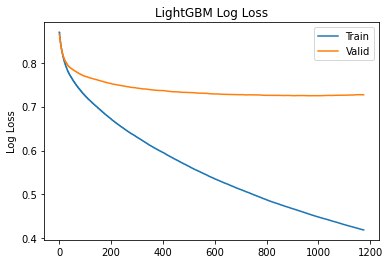


              precision    recall  f1-score   support

         0.0       0.40      0.27      0.32       795
         1.0       0.56      0.49      0.52      1555
         2.0       0.76      0.84      0.80      4265

    accuracy                           0.69      6615
   macro avg       0.57      0.53      0.55      6615
weighted avg       0.67      0.69      0.68      6615

          feature  importance
6     begin_month    0.344942
3      DAYS_BIRTH    0.152799
5   DAYS_EMPLOYED    0.113532
0    income_total    0.110203
17     occyp_type    0.055949
11    family_type    0.026339
10       edu_type    0.022688
2     family_size    0.021754
15    income_type    0.020361
14          phone    0.019776
7          gender    0.018864
9         reality    0.017535
8             car    0.016567
13     work_phone    0.016333
12     house_type    0.015927
1       child_num    0.015562
16          email    0.010868
4      FLAG_MOBIL    0.000000


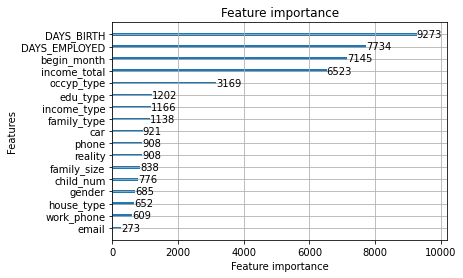

In [ ]:
label_cols = ['gender', 'car', 'reality',  
                  'edu_type', 'family_type', 'house_type',
                   'work_phone', 'phone', 'income_type',
                  'email','occyp_type', ]
#onehot_cols = ['gender','car','reality',]
numerical_cols =['income_total','child_num','family_size', 'DAYS_BIRTH','FLAG_MOBIL', 'DAYS_EMPLOYED', 'begin_month']
df1_train,df1_test,logloss =make_temp(label_cols, numerical_cols,1)
df_logloss.update({'df_1': logloss})

In [ ]:
print(df_logloss)

{'df_1': 0.7246931865008024}


### 변수 삭제

[1]	training's multi_logloss: 0.869451	training's multi_logloss: 0.869451	valid_1's multi_logloss: 0.864535	valid_1's multi_logloss: 0.864535
Training until validation scores don't improve for 100 rounds.
[2]	training's multi_logloss: 0.857892	training's multi_logloss: 0.857892	valid_1's multi_logloss: 0.854003	valid_1's multi_logloss: 0.854003
[3]	training's multi_logloss: 0.848419	training's multi_logloss: 0.848419	valid_1's multi_logloss: 0.845649	valid_1's multi_logloss: 0.845649
[4]	training's multi_logloss: 0.840322	training's multi_logloss: 0.840322	valid_1's multi_logloss: 0.838407	valid_1's multi_logloss: 0.838407
[5]	training's multi_logloss: 0.83331	training's multi_logloss: 0.83331	valid_1's multi_logloss: 0.83242	valid_1's multi_logloss: 0.83242
[6]	training's multi_logloss: 0.826953	training's multi_logloss: 0.826953	valid_1's multi_logloss: 0.826892	valid_1's multi_logloss: 0.826892
[7]	training's multi_logloss: 0.821524	training's multi_logloss: 0.821524	valid_1's multi

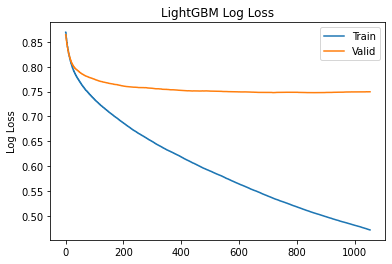

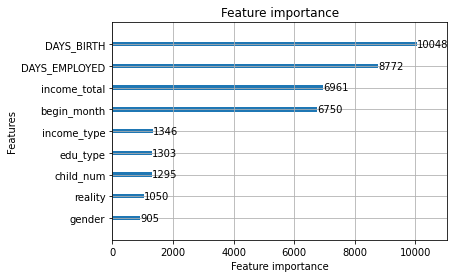

In [ ]:
label_cols = ['income_type','edu_type','child_num','gender','reality']
#onehot_cols = ['gender','car','reality',]
numerical_cols =['income_total',  'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']
df2_train,df2_test,logloss=make_temp(label_cols,numerical_cols)
df_logloss.update({'df_2': logloss})

## 전처리

In [ ]:
all_df

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,X,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,36452,F,Y,Y,0,202500.0,Working,Incomplete higher,Married,House / apartment,-18593,-5434,1,1,1,0,Accountants,2.0,-19.0,NaN
36453,36453,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,1,0,0,Laborers,2.0,-34.0,NaN
36454,36454,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,1,0,0,0,Medicine staff,2.0,-55.0,NaN
36455,36455,F,Y,N,0,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-16541,-1085,1,0,1,0,X,2.0,-33.0,NaN


In [ ]:
#나이 전처리
Age=np.abs(all_df['DAYS_BIRTH'])
Age=np.round(Age/365)
all_df['DAYS_BIRTH']=Age
all_df['DAYS_BIRTH']

# 고용일자 전처리
Year_Employ=np.abs(all_df['DAYS_EMPLOYED'])
Year_Employ=np.ceil(Year_Employ/365)
all_df['DAYS_EMPLOYED']=Year_Employ

# 아이 유무 전처리
all_df['child_num']=all_df['child_num'].map(lambda x:1 if (x >0) else 0)


# log 처리
all_df['income_total'] = np.log(all_df['income_total'])


# 카드 발급일 전처리
month=np.abs(all_df['begin_month'])
all_df['begin_month']=month


# train_dup = temp.iloc[:26457, :]#0개~100000개
# test_dup = temp.iloc[26457:, :] #100000개~ 


In [ ]:
all_df['DAYS_BIRTH'].unique()

array([38., 31., 52., 41., 37., 48., 43., 32., 33., 27., 63., 35., 53.,
       24., 54., 58., 42., 40., 61., 39., 49., 47., 36., 55., 46., 59.,
       51., 50., 65., 66., 44., 64., 25., 28., 34., 56., 26., 30., 29.,
       62., 57., 45., 67., 60., 23., 68., 22., 21., 69.])

In [ ]:
all_df

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,12.218495,Commercial associate,Higher education,Married,Municipal apartment,38.0,13.0,1,0,0,0,X,2.0,6.0,1.0
1,1,F,N,Y,1,12.419166,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,31.0,5.0,1,0,0,1,Laborers,3.0,5.0,1.0
2,2,M,Y,Y,0,13.017003,Working,Higher education,Married,House / apartment,52.0,13.0,1,0,1,0,Managers,2.0,22.0,2.0
3,3,F,N,Y,0,12.218495,Commercial associate,Secondary / secondary special,Married,House / apartment,41.0,6.0,1,0,1,0,Sales staff,2.0,37.0,0.0
4,4,F,Y,Y,0,11.967181,State servant,Higher education,Married,House / apartment,41.0,6.0,1,0,0,0,Managers,2.0,26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,36452,F,Y,Y,0,12.218495,Working,Incomplete higher,Married,House / apartment,51.0,15.0,1,1,1,0,Accountants,2.0,19.0,NaN
36453,36453,M,Y,Y,0,12.218495,Working,Secondary / secondary special,Civil marriage,House / apartment,30.0,4.0,1,1,0,0,Laborers,2.0,34.0,NaN
36454,36454,F,N,Y,0,12.586220,Working,Secondary / secondary special,Married,House / apartment,58.0,39.0,1,0,0,0,Medicine staff,2.0,55.0,NaN
36455,36455,F,Y,N,0,12.100712,Commercial associate,Secondary / secondary special,Married,House / apartment,45.0,3.0,1,0,1,0,X,2.0,33.0,NaN


## 데이터 전처리 후 encoding

[1]	training's multi_logloss: 0.867802	training's multi_logloss: 0.867802	valid_1's multi_logloss: 0.863933	valid_1's multi_logloss: 0.863933
Training until validation scores don't improve for 100 rounds.
[2]	training's multi_logloss: 0.854821	training's multi_logloss: 0.854821	valid_1's multi_logloss: 0.852935	valid_1's multi_logloss: 0.852935
[3]	training's multi_logloss: 0.843975	training's multi_logloss: 0.843975	valid_1's multi_logloss: 0.84407	valid_1's multi_logloss: 0.84407
[4]	training's multi_logloss: 0.834306	training's multi_logloss: 0.834306	valid_1's multi_logloss: 0.836386	valid_1's multi_logloss: 0.836386
[5]	training's multi_logloss: 0.826254	training's multi_logloss: 0.826254	valid_1's multi_logloss: 0.830139	valid_1's multi_logloss: 0.830139
[6]	training's multi_logloss: 0.818998	training's multi_logloss: 0.818998	valid_1's multi_logloss: 0.824906	valid_1's multi_logloss: 0.824906
[7]	training's multi_logloss: 0.812537	training's multi_logloss: 0.812537	valid_1's mul

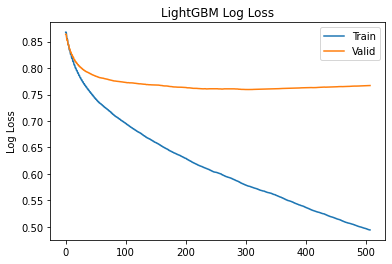

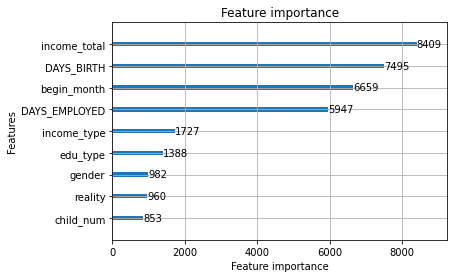

In [ ]:
label_cols = ['income_type','edu_type','child_num','gender','reality']
#onehot_cols = ['gender','car','reality',]
numerical_cols =['income_total',  'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']
df3_train,df3_test,logloss=make_temp(label_cols,numerical_cols)
df_logloss.update({'df_3': logloss})

## 다양한 변수 교체 

In [ ]:
all_df

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,12.218495,Commercial associate,Higher education,Married,Municipal apartment,38.0,13.0,1,0,0,0,X,2.0,6.0,1.0
1,1,F,N,Y,1,12.419166,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,31.0,5.0,1,0,0,1,Laborers,3.0,5.0,1.0
2,2,M,Y,Y,0,13.017003,Working,Higher education,Married,House / apartment,52.0,13.0,1,0,1,0,Managers,2.0,22.0,2.0
3,3,F,N,Y,0,12.218495,Commercial associate,Secondary / secondary special,Married,House / apartment,41.0,6.0,1,0,1,0,Sales staff,2.0,37.0,0.0
4,4,F,Y,Y,0,11.967181,State servant,Higher education,Married,House / apartment,41.0,6.0,1,0,0,0,Managers,2.0,26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,36452,F,Y,Y,0,12.218495,Working,Incomplete higher,Married,House / apartment,51.0,15.0,1,1,1,0,Accountants,2.0,19.0,NaN
36453,36453,M,Y,Y,0,12.218495,Working,Secondary / secondary special,Civil marriage,House / apartment,30.0,4.0,1,1,0,0,Laborers,2.0,34.0,NaN
36454,36454,F,N,Y,0,12.586220,Working,Secondary / secondary special,Married,House / apartment,58.0,39.0,1,0,0,0,Medicine staff,2.0,55.0,NaN
36455,36455,F,Y,N,0,12.100712,Commercial associate,Secondary / secondary special,Married,House / apartment,45.0,3.0,1,0,1,0,X,2.0,33.0,NaN


[1]	training's multi_logloss: 0.867674	training's multi_logloss: 0.867674	valid_1's multi_logloss: 0.863815	valid_1's multi_logloss: 0.863815
Training until validation scores don't improve for 100 rounds.
[2]	training's multi_logloss: 0.854559	training's multi_logloss: 0.854559	valid_1's multi_logloss: 0.852771	valid_1's multi_logloss: 0.852771
[3]	training's multi_logloss: 0.843371	training's multi_logloss: 0.843371	valid_1's multi_logloss: 0.843658	valid_1's multi_logloss: 0.843658
[4]	training's multi_logloss: 0.833979	training's multi_logloss: 0.833979	valid_1's multi_logloss: 0.836355	valid_1's multi_logloss: 0.836355
[5]	training's multi_logloss: 0.825788	training's multi_logloss: 0.825788	valid_1's multi_logloss: 0.830086	valid_1's multi_logloss: 0.830086
[6]	training's multi_logloss: 0.818152	training's multi_logloss: 0.818152	valid_1's multi_logloss: 0.824453	valid_1's multi_logloss: 0.824453
[7]	training's multi_logloss: 0.811148	training's multi_logloss: 0.811148	valid_1's m

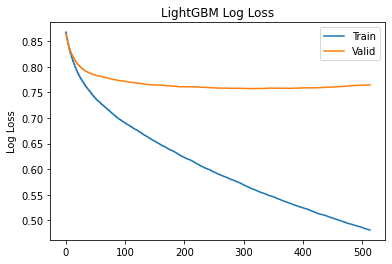

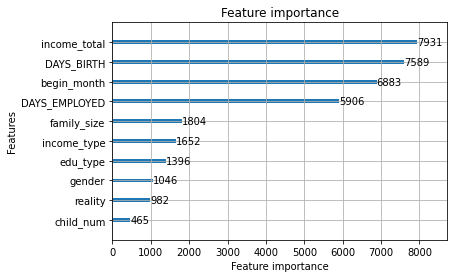

In [ ]:
label_cols = ['income_type','edu_type','child_num','gender','reality']
#onehot_cols = ['gender','car','reality',]
numerical_cols =['income_total',  'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month','family_size']
df4_train,df4_test,logloss=make_temp(label_cols,numerical_cols)
df_logloss.update({'df_4': logloss})

[1]	training's multi_logloss: 0.870519	training's multi_logloss: 0.870519	valid_1's multi_logloss: 0.865046	valid_1's multi_logloss: 0.865046
Training until validation scores don't improve for 10 rounds.
[2]	training's multi_logloss: 0.859907	training's multi_logloss: 0.859907	valid_1's multi_logloss: 0.854928	valid_1's multi_logloss: 0.854928
[3]	training's multi_logloss: 0.851326	training's multi_logloss: 0.851326	valid_1's multi_logloss: 0.846842	valid_1's multi_logloss: 0.846842
[4]	training's multi_logloss: 0.843988	training's multi_logloss: 0.843988	valid_1's multi_logloss: 0.840106	valid_1's multi_logloss: 0.840106
[5]	training's multi_logloss: 0.837799	training's multi_logloss: 0.837799	valid_1's multi_logloss: 0.83448	valid_1's multi_logloss: 0.83448
[6]	training's multi_logloss: 0.832489	training's multi_logloss: 0.832489	valid_1's multi_logloss: 0.829746	valid_1's multi_logloss: 0.829746
[7]	training's multi_logloss: 0.827856	training's multi_logloss: 0.827856	valid_1's mult

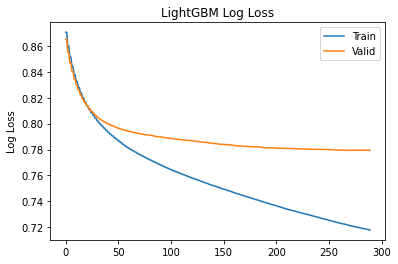

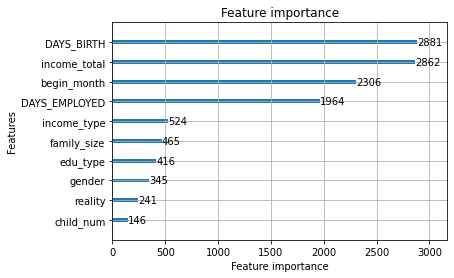

In [ ]:
label_cols = ['income_type','edu_type','child_num','gender','reality']
#onehot_cols = ['gender','car','reality',]
numerical_cols =['income_total',  'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month','family_size']
t_df4_train,t_df4_test,logloss=tun_make_temp(label_cols,numerical_cols)
df_logloss.update({'t_df_4': logloss})

[1]	training's multi_logloss: 0.869787	training's multi_logloss: 0.869787	valid_1's multi_logloss: 0.864908	valid_1's multi_logloss: 0.864908
Training until validation scores don't improve for 100 rounds.
[2]	training's multi_logloss: 0.858657	training's multi_logloss: 0.858657	valid_1's multi_logloss: 0.854596	valid_1's multi_logloss: 0.854596
[3]	training's multi_logloss: 0.849346	training's multi_logloss: 0.849346	valid_1's multi_logloss: 0.846091	valid_1's multi_logloss: 0.846091
[4]	training's multi_logloss: 0.841547	training's multi_logloss: 0.841547	valid_1's multi_logloss: 0.839053	valid_1's multi_logloss: 0.839053
[5]	training's multi_logloss: 0.834831	training's multi_logloss: 0.834831	valid_1's multi_logloss: 0.833043	valid_1's multi_logloss: 0.833043
[6]	training's multi_logloss: 0.828961	training's multi_logloss: 0.828961	valid_1's multi_logloss: 0.828088	valid_1's multi_logloss: 0.828088
[7]	training's multi_logloss: 0.823758	training's multi_logloss: 0.823758	valid_1's m

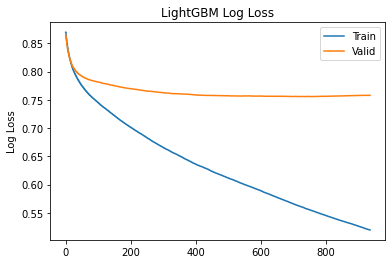

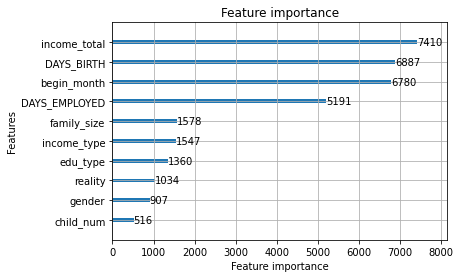

In [ ]:
label_cols = ['income_type','edu_type','child_num','gender','reality', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month','family_size']
#onehot_cols = ['gender','car','reality',]
numerical_cols =['income_total',]

df5_train,df5_test,logloss=make_temp(label_cols,numerical_cols)
df_logloss.update({'df_5': logloss})


[1]	training's multi_logloss: 0.869888	training's multi_logloss: 0.869888	valid_1's multi_logloss: 0.864907	valid_1's multi_logloss: 0.864907
Training until validation scores don't improve for 100 rounds.
[2]	training's multi_logloss: 0.858767	training's multi_logloss: 0.858767	valid_1's multi_logloss: 0.854798	valid_1's multi_logloss: 0.854798
[3]	training's multi_logloss: 0.849393	training's multi_logloss: 0.849393	valid_1's multi_logloss: 0.846252	valid_1's multi_logloss: 0.846252
[4]	training's multi_logloss: 0.8417	training's multi_logloss: 0.8417	valid_1's multi_logloss: 0.839336	valid_1's multi_logloss: 0.839336
[5]	training's multi_logloss: 0.835007	training's multi_logloss: 0.835007	valid_1's multi_logloss: 0.833256	valid_1's multi_logloss: 0.833256
[6]	training's multi_logloss: 0.829328	training's multi_logloss: 0.829328	valid_1's multi_logloss: 0.828386	valid_1's multi_logloss: 0.828386
[7]	training's multi_logloss: 0.824105	training's multi_logloss: 0.824105	valid_1's multi

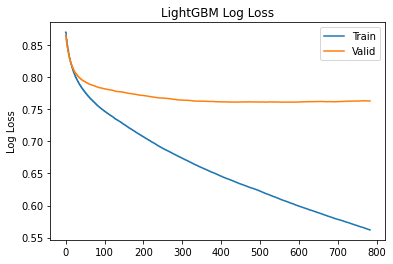

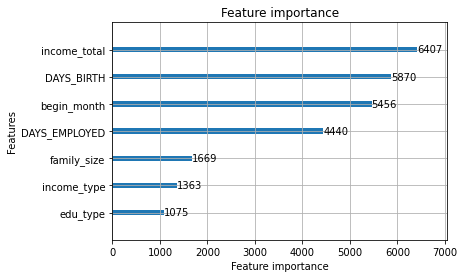

In [ ]:
label_cols = ['income_type','edu_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month','family_size']
#onehot_cols = ['gender','car','reality',]
numerical_cols =['income_total',]

df6_train,df6_test,logloss=make_temp(label_cols,numerical_cols)
df_logloss.update({'df_6': logloss})

In [ ]:
# label_cols = ['gender', 'car', 'reality',  
#                   'edu_type', 'family_type', 'house_type',
#                    'work_phone', 'phone', 'income_type',
#                   'email','occyp_type', ]
# #onehot_cols = ['gender','car','reality',]
# numerical_cols =['income_total','child_num','family_size', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']
# df7_train,df7_test,logloss=make_temp(label_cols,numerical_cols)
# df_logloss.update({'df_7': logloss})

In [ ]:
# label_cols = ['gender', 'car', 'reality',  
#                   'edu_type', 'family_type', 'house_type',
#                    'work_phone', 'phone', 'income_type',
#                   'email','occyp_type', 'child_num', ]
# #onehot_cols = ['gender','car','reality',]
# numerical_cols =['income_total','family_size','DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']
# df9_train,df9_test,logloss=make_temp(label_cols,numerical_cols)
# df_logloss.update({'df_9': logloss})

[1]	training's multi_logloss: 0.8699	training's multi_logloss: 0.8699	valid_1's multi_logloss: 0.86493	valid_1's multi_logloss: 0.86493
Training until validation scores don't improve for 100 rounds.
[2]	training's multi_logloss: 0.858853	training's multi_logloss: 0.858853	valid_1's multi_logloss: 0.854744	valid_1's multi_logloss: 0.854744
[3]	training's multi_logloss: 0.849667	training's multi_logloss: 0.849667	valid_1's multi_logloss: 0.846247	valid_1's multi_logloss: 0.846247
[4]	training's multi_logloss: 0.842054	training's multi_logloss: 0.842054	valid_1's multi_logloss: 0.839499	valid_1's multi_logloss: 0.839499
[5]	training's multi_logloss: 0.835549	training's multi_logloss: 0.835549	valid_1's multi_logloss: 0.833552	valid_1's multi_logloss: 0.833552
[6]	training's multi_logloss: 0.82989	training's multi_logloss: 0.82989	valid_1's multi_logloss: 0.828762	valid_1's multi_logloss: 0.828762
[7]	training's multi_logloss: 0.82468	training's multi_logloss: 0.82468	valid_1's multi_loglo

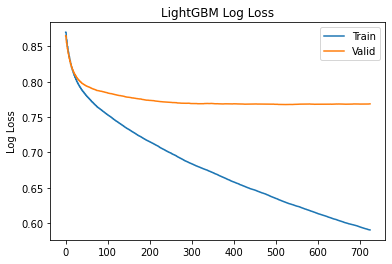

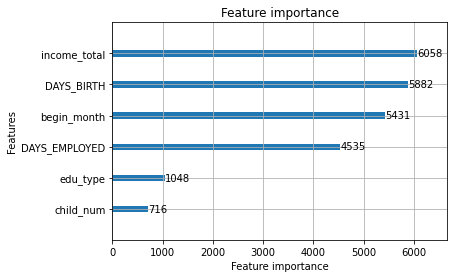

In [ ]:
label_cols = ['edu_type', 'child_num', ]
#onehot_cols = ['gender','car','reality',]
numerical_cols =['income_total','DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']
df11_train,df11_test,logloss=make_temp(label_cols,numerical_cols)
df_logloss.update({'df_11': logloss})

[1]	training's multi_logloss: 0.870671	training's multi_logloss: 0.870671	valid_1's multi_logloss: 0.865172	valid_1's multi_logloss: 0.865172
Training until validation scores don't improve for 20 rounds.
[2]	training's multi_logloss: 0.860269	training's multi_logloss: 0.860269	valid_1's multi_logloss: 0.855189	valid_1's multi_logloss: 0.855189
[3]	training's multi_logloss: 0.851886	training's multi_logloss: 0.851886	valid_1's multi_logloss: 0.847162	valid_1's multi_logloss: 0.847162
[4]	training's multi_logloss: 0.84482	training's multi_logloss: 0.84482	valid_1's multi_logloss: 0.840553	valid_1's multi_logloss: 0.840553
[5]	training's multi_logloss: 0.838875	training's multi_logloss: 0.838875	valid_1's multi_logloss: 0.834939	valid_1's multi_logloss: 0.834939
[6]	training's multi_logloss: 0.83367	training's multi_logloss: 0.83367	valid_1's multi_logloss: 0.830222	valid_1's multi_logloss: 0.830222
[7]	training's multi_logloss: 0.829003	training's multi_logloss: 0.829003	valid_1's multi_

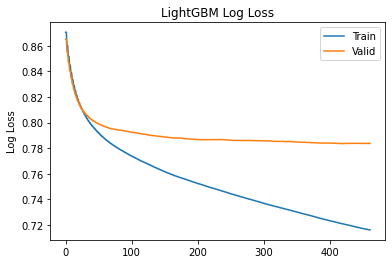

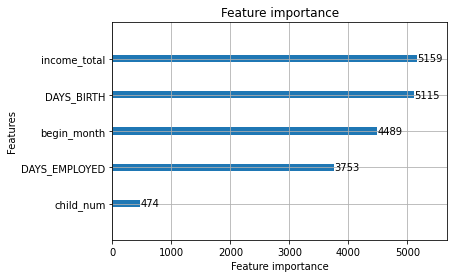

In [ ]:
label_cols = ['child_num']
#onehot_cols = ['gender','car','reality',]
numerical_cols =['income_total','DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month', ]
df17_train,df17_test,logloss=tun_make_temp(label_cols,numerical_cols)
df_logloss.update({'df_17': logloss})

In [ ]:
df17_test

,income_total,DAYS_BIRTH,DAYS_EMPLOYED,begin_month,child_num
0,11.630709,60.0,0.0,60.0,0
1,11.813030,52.0,24.0,36.0,0
2,11.147239,44.0,1.0,40.0,0
3,11.630709,53.0,7.0,41.0,0
4,12.323856,49.0,26.0,8.0,0
...,...,...,...,...,...
9995,12.218495,51.0,15.0,19.0,0
9996,12.218495,30.0,4.0,34.0,0
9997,12.586220,58.0,39.0,55.0,0
9998,12.100712,45.0,3.0,33.0,0


In [ ]:
df_logloss

{'df_1': 0.7246931865008024,
 'df_10': 0.7868996462546218,
 'df_11': 0.7676916944960005,
 'df_12': 0.8041356901660085,
 'df_13': 0.7736037037508302,
 'df_14': 0.8075567231172424,
 'df_15': 0.7599993700386697,
 'df_16': 0.8011078484452299,
 'df_2': 0.7477950393728944,
 'df_3': 0.7594669030165608,
 'df_4': 0.757504519429135,
 'df_5': 0.7557458933862964,
 'df_6': 0.7609520064276842,
 'df_8': 0.7869122023227204,
 't_df_12': 0.813931972326401,
 't_df_4': 0.7793745406975506}

[1]	training's multi_logloss: 0.870676	training's multi_logloss: 0.870676	valid_1's multi_logloss: 0.865166	valid_1's multi_logloss: 0.865166
Training until validation scores don't improve for 10 rounds.
[2]	training's multi_logloss: 0.86028	training's multi_logloss: 0.86028	valid_1's multi_logloss: 0.855134	valid_1's multi_logloss: 0.855134
[3]	training's multi_logloss: 0.851898	training's multi_logloss: 0.851898	valid_1's multi_logloss: 0.847105	valid_1's multi_logloss: 0.847105
[4]	training's multi_logloss: 0.844895	training's multi_logloss: 0.844895	valid_1's multi_logloss: 0.840469	valid_1's multi_logloss: 0.840469
[5]	training's multi_logloss: 0.838791	training's multi_logloss: 0.838791	valid_1's multi_logloss: 0.83479	valid_1's multi_logloss: 0.83479
[6]	training's multi_logloss: 0.833705	training's multi_logloss: 0.833705	valid_1's multi_logloss: 0.830149	valid_1's multi_logloss: 0.830149
[7]	training's multi_logloss: 0.829269	training's multi_logloss: 0.829269	valid_1's multi_

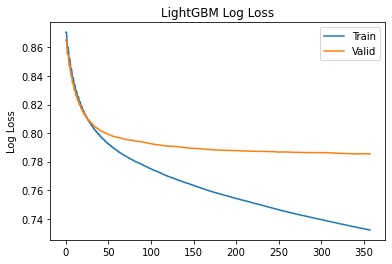

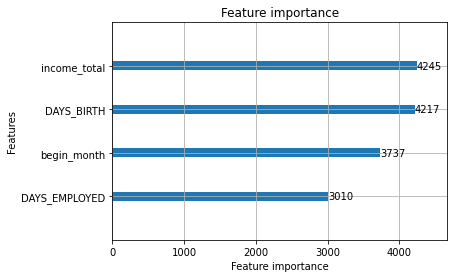

In [ ]:
label_cols = [ 'DAYS_EMPLOYED', 'begin_month']
#onehot_cols = ['gender','car','reality',]
numerical_cols =['income_total','DAYS_BIRTH', ]
df13_train,df13_test,logloss=tun_make_temp(label_cols,numerical_cols)
df_logloss.update({'df_13': logloss})

In [ ]:
print(df_logloss)

{'df_1': 0.7246931865008024, 'df_2': 0.7477950393728944, 'df_3': 0.7622467531832035, 'df_4': 0.7557420190144097, 'df_5': 0.7557458933862964, 'df_6': 0.7609520064276842, 'df_11': 0.7676916944960005, 'df_13': 0.7736037037508302}


In [ ]:
df_logloss

{'df_1': 0.7246931865008024,
 'df_10': 0.7868996462546218,
 'df_11': 0.7676916944960005,
 'df_12': 0.8041356901660085,
 'df_13': 0.7736037037508302,
 'df_14': 0.8075567231172424,
 'df_15': 0.7599993700386697,
 'df_16': 0.8011078484452299,
 'df_2': 0.7477950393728944,
 'df_3': 0.7594669030165608,
 'df_4': 0.757504519429135,
 'df_5': 0.7557458933862964,
 'df_6': 0.7609520064276842,
 'df_8': 0.7869122023227204,
 't_df_4': 0.7885433581026242}

[1]	training's multi_logloss: 0.869964	training's multi_logloss: 0.869964	valid_1's multi_logloss: 0.864922	valid_1's multi_logloss: 0.864922
Training until validation scores don't improve for 100 rounds.
[2]	training's multi_logloss: 0.858891	training's multi_logloss: 0.858891	valid_1's multi_logloss: 0.854684	valid_1's multi_logloss: 0.854684
[3]	training's multi_logloss: 0.849901	training's multi_logloss: 0.849901	valid_1's multi_logloss: 0.846209	valid_1's multi_logloss: 0.846209
[4]	training's multi_logloss: 0.842426	training's multi_logloss: 0.842426	valid_1's multi_logloss: 0.839341	valid_1's multi_logloss: 0.839341
[5]	training's multi_logloss: 0.835695	training's multi_logloss: 0.835695	valid_1's multi_logloss: 0.833282	valid_1's multi_logloss: 0.833282
[6]	training's multi_logloss: 0.829981	training's multi_logloss: 0.829981	valid_1's multi_logloss: 0.828433	valid_1's multi_logloss: 0.828433
[7]	training's multi_logloss: 0.82489	training's multi_logloss: 0.82489	valid_1's mul

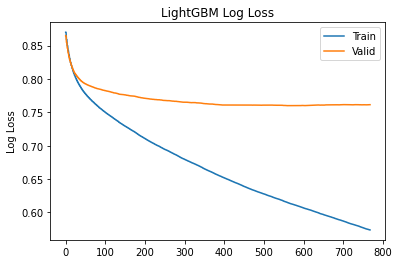

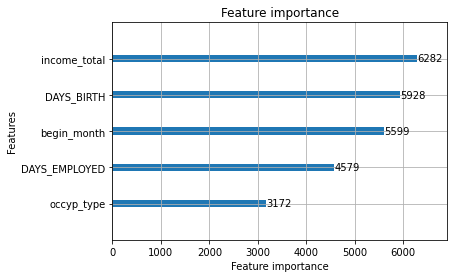

In [ ]:
label_cols = ['occyp_type',]
#onehot_cols = ['gender','car','reality',]
numerical_cols =['income_total',  'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']
df15_train,df15_test,logloss=make_temp(label_cols,numerical_cols)
df_logloss.update({'df_15': logloss})

## 중복 데이터 처리

In [ ]:
dup_df=all_df[all_df.columns.drop("index")].drop_duplicates(keep=False)
dup_df.shape
dup_df

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,12.218495,Commercial associate,Higher education,Married,Municipal apartment,38.0,13.0,1,0,0,0,X,2.0,6.0,1.0
1,F,N,Y,1,12.419166,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,31.0,5.0,1,0,0,1,Laborers,3.0,5.0,1.0
2,M,Y,Y,0,13.017003,Working,Higher education,Married,House / apartment,52.0,13.0,1,0,1,0,Managers,2.0,22.0,2.0
3,F,N,Y,0,12.218495,Commercial associate,Secondary / secondary special,Married,House / apartment,41.0,6.0,1,0,1,0,Sales staff,2.0,37.0,0.0
4,F,Y,Y,0,11.967181,State servant,Higher education,Married,House / apartment,41.0,6.0,1,0,0,0,Managers,2.0,26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36451,M,Y,Y,0,11.786001,Pensioner,Secondary / secondary special,Married,House / apartment,65.0,0.0,1,0,0,0,X,2.0,3.0,NaN
36452,F,Y,Y,0,12.218495,Working,Incomplete higher,Married,House / apartment,51.0,15.0,1,1,1,0,Accountants,2.0,19.0,NaN
36454,F,N,Y,0,12.586220,Working,Secondary / secondary special,Married,House / apartment,58.0,39.0,1,0,0,0,Medicine staff,2.0,55.0,NaN
36455,F,Y,N,0,12.100712,Commercial associate,Secondary / secondary special,Married,House / apartment,45.0,3.0,1,0,1,0,X,2.0,33.0,NaN


In [ ]:
dup_df.isnull().sum()

gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type          0
family_size         0
begin_month         0
credit           9297
dtype: int64

In [ ]:
dup_df=dup_df.reset_index(drop=True)

In [ ]:
def make_dup_temp(label_cols, numerical_cols,drop_list=["index"],rf_pick=0):
    train_temp = all_df.iloc[:26457, :]#0개~100000개
    test_temp = all_df.iloc[26457:, :] #100000개~ 


    label_encoder= LabelEncoder()


    train_dup=train_temp[train_temp.columns.drop(drop_list)].drop_duplicates(keep=False).reset_index(drop=True)
    test_dup=test_temp[test_temp.columns.drop(drop_list)].drop_duplicates(keep=False).reset_index(drop=True)
    #트레인 데이터
    label_train_encoded_df = pd.DataFrame(columns=label_cols)
    label_test_encoded_df = pd.DataFrame(columns=label_cols)
    for i in label_cols:
      label_train_encoded_df[i]=label_encoder.fit_transform(train_dup[i])
      label_test_encoded_df[i]=label_encoder.transform(test_dup[i])


    #label_encoded_df = train_dup[label_cols].apply(label_encoder.fit_transform)
    #numerical_df = pd.DataFrame(scaler.fit_transform(train_dup[numerical_cols]), columns=numerical_cols)
    numerical_df = train_dup[numerical_cols]
    target_df = train_dup[TARGET]
    train= pd.concat([numerical_df, label_train_encoded_df, target_df], axis=1)

    #test 데이터
    #label_encoded_df = test_dup[label_cols].apply(label_encoder.transform)
    #numerical_df = pd.DataFrame(scaler.transform(test_dup[numerical_cols]), columns=numerical_cols)
    numerical_df = test_dup[numerical_cols]
    target_df = test_dup[TARGET]
    test= pd.concat([numerical_df, label_test_encoded_df, target_df], axis=1)


    test = test.drop(TARGET, axis=1) #test에서 종속변수를 드랍한다. 
    
    y= train.loc[:,TARGET]
    X= train.drop(TARGET,axis=1)

    logloss=Simple_lightGBM(X,y)

    
    if rf_pick==1:
        X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.25, random_state=21)
        rf = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)
        cross_val_score(rf, X_train, y_train, cv=3)
        rf.score(X_valid, y_valid)
        print(classification_report(y_valid, rf.predict(X_valid)))

        feature_importance_rf = pd.DataFrame(zip(X.columns.values, rf.feature_importances_))
        feature_importance_rf.columns = ['feature', 'importance']
        feature_importance_rf.sort_values("importance", ascending=False, inplace=True)
        print(feature_importance_rf)
        
    
    return train,test,logloss

In [ ]:
def tun_make_dup_temp(label_cols, numerical_cols,drop_list=["index"],rf_pick=0):
    train_temp = all_df.iloc[:26457, :]#0개~100000개
    test_temp = all_df.iloc[26457:, :] #100000개~ 
    #test_temp.reset_index(drop=True)


    label_encoder= LabelEncoder()


    train_dup=train_temp[train_temp.columns.drop(drop_list)].drop_duplicates(keep=False).reset_index(drop=True)
    #test_dup=test_temp[test_temp.columns.drop(drop_list)].drop_duplicates(keep=False).reset_index(drop=True)
    #트레인 데이터
    label_train_encoded_df = pd.DataFrame(columns=label_cols)
    label_test_encoded_df = pd.DataFrame(columns=label_cols)
    for i in label_cols:

      label_train_encoded_df[i]=label_encoder.fit_transform(train_dup[i])
      label_test_encoded_df[i]=label_encoder.transform(test_temp[i])

    print(label_test_encoded_df)
    #label_encoded_df = train_dup[label_cols].apply(label_encoder.fit_transform)
    #numerical_df = pd.DataFrame(scaler.fit_transform(train_dup[numerical_cols]), columns=numerical_cols)
    numerical_df = train_dup[numerical_cols]
    target_df = train_dup[TARGET]
    train= pd.concat([numerical_df, label_train_encoded_df, target_df], axis=1)

    #test 데이터
    #label_encoded_df = test_dup[label_cols].apply(label_encoder.transform)
    #numerical_df = pd.DataFrame(scaler.transform(test_dup[numerical_cols]), columns=numerical_cols)
    test_numerical_df = test_temp[numerical_cols].reset_index(drop=True)
    #test_target_df = test_temp[TARGET]
    test= pd.concat([test_numerical_df, label_test_encoded_df], axis=1)


    #test = test.drop(TARGET, axis=1) #test에서 종속변수를 드랍한다. 
    
    y= train.loc[:,TARGET]
    X= train.drop(TARGET,axis=1)

    logloss=Some_lightGBM(X,y)

    
    if rf_pick==1:
        X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.25, random_state=21)
        rf = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)
        cross_val_score(rf, X_train, y_train, cv=3)
        rf.score(X_valid, y_valid)
        print(classification_report(y_valid, rf.predict(X_valid)))

        feature_importance_rf = pd.DataFrame(zip(X.columns.values, rf.feature_importances_))
        feature_importance_rf.columns = ['feature', 'importance']
        feature_importance_rf.sort_values("importance", ascending=False, inplace=True)
        print(feature_importance_rf)
        
    
    return train,test,logloss

[1]	training's multi_logloss: 0.876731	training's multi_logloss: 0.876731	valid_1's multi_logloss: 0.882715	valid_1's multi_logloss: 0.882715
Training until validation scores don't improve for 100 rounds.
[2]	training's multi_logloss: 0.865737	training's multi_logloss: 0.865737	valid_1's multi_logloss: 0.87204	valid_1's multi_logloss: 0.87204
[3]	training's multi_logloss: 0.856519	training's multi_logloss: 0.856519	valid_1's multi_logloss: 0.863545	valid_1's multi_logloss: 0.863545
[4]	training's multi_logloss: 0.84874	training's multi_logloss: 0.84874	valid_1's multi_logloss: 0.856465	valid_1's multi_logloss: 0.856465
[5]	training's multi_logloss: 0.842213	training's multi_logloss: 0.842213	valid_1's multi_logloss: 0.850589	valid_1's multi_logloss: 0.850589
[6]	training's multi_logloss: 0.836364	training's multi_logloss: 0.836364	valid_1's multi_logloss: 0.845416	valid_1's multi_logloss: 0.845416
[7]	training's multi_logloss: 0.830936	training's multi_logloss: 0.830936	valid_1's multi

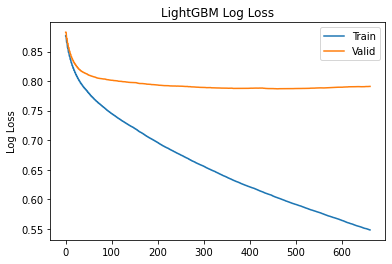

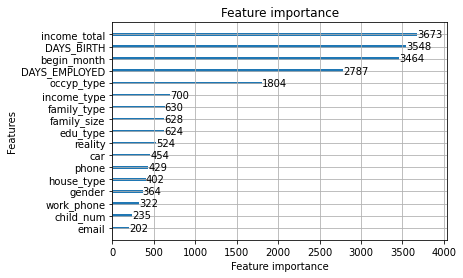

In [ ]:
label_cols = ['gender', 'car', 'reality',  
                  'edu_type', 'family_type', 'house_type',
                   'work_phone', 'phone', 'income_type',
                  'email','occyp_type', ]
#onehot_cols = ['gender','car','reality',]
numerical_cols =['income_total','child_num','family_size', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']
df8_train,df8_test,logloss=make_dup_temp(label_cols,numerical_cols)
df_logloss.update({'df_8': logloss})

[1]	training's multi_logloss: 0.87708	training's multi_logloss: 0.87708	valid_1's multi_logloss: 0.882861	valid_1's multi_logloss: 0.882861
Training until validation scores don't improve for 100 rounds.
[2]	training's multi_logloss: 0.866327	training's multi_logloss: 0.866327	valid_1's multi_logloss: 0.872195	valid_1's multi_logloss: 0.872195
[3]	training's multi_logloss: 0.857517	training's multi_logloss: 0.857517	valid_1's multi_logloss: 0.863751	valid_1's multi_logloss: 0.863751
[4]	training's multi_logloss: 0.850097	training's multi_logloss: 0.850097	valid_1's multi_logloss: 0.856831	valid_1's multi_logloss: 0.856831
[5]	training's multi_logloss: 0.84381	training's multi_logloss: 0.84381	valid_1's multi_logloss: 0.851191	valid_1's multi_logloss: 0.851191
[6]	training's multi_logloss: 0.838429	training's multi_logloss: 0.838429	valid_1's multi_logloss: 0.846341	valid_1's multi_logloss: 0.846341
[7]	training's multi_logloss: 0.833537	training's multi_logloss: 0.833537	valid_1's multi

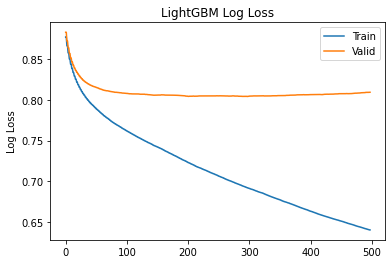

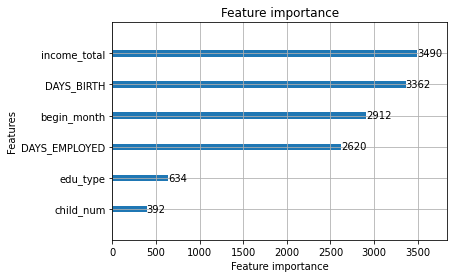

In [ ]:
label_cols = ['edu_type', 'child_num', ]
#onehot_cols = ['gender','car','reality',]
numerical_cols =['income_total','DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']
df12_train,df12_test,logloss=make_dup_temp(label_cols,numerical_cols)
df_logloss.update({'df_12': logloss})

[1]	training's multi_logloss: 0.876731	training's multi_logloss: 0.876731	valid_1's multi_logloss: 0.882715	valid_1's multi_logloss: 0.882715
Training until validation scores don't improve for 100 rounds.
[2]	training's multi_logloss: 0.865737	training's multi_logloss: 0.865737	valid_1's multi_logloss: 0.87204	valid_1's multi_logloss: 0.87204
[3]	training's multi_logloss: 0.856519	training's multi_logloss: 0.856519	valid_1's multi_logloss: 0.863542	valid_1's multi_logloss: 0.863542
[4]	training's multi_logloss: 0.84874	training's multi_logloss: 0.84874	valid_1's multi_logloss: 0.85646	valid_1's multi_logloss: 0.85646
[5]	training's multi_logloss: 0.842213	training's multi_logloss: 0.842213	valid_1's multi_logloss: 0.850585	valid_1's multi_logloss: 0.850585
[6]	training's multi_logloss: 0.836364	training's multi_logloss: 0.836364	valid_1's multi_logloss: 0.845412	valid_1's multi_logloss: 0.845412
[7]	training's multi_logloss: 0.830936	training's multi_logloss: 0.830936	valid_1's multi_l

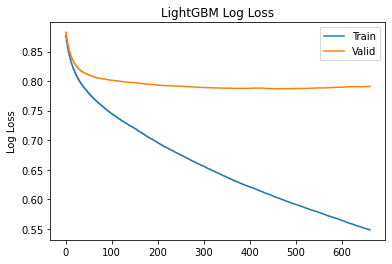

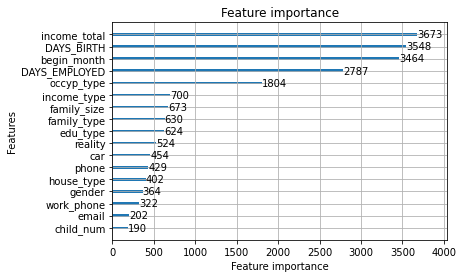

In [ ]:
label_cols = ['gender', 'car', 'reality',  
                  'edu_type', 'family_type', 'house_type',
                   'work_phone', 'phone', 'income_type',
                  'email','occyp_type', 'child_num', ]
#onehot_cols = ['gender','car','reality',]
numerical_cols =['income_total','family_size','DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']
df10_train,df10_test,logloss=make_dup_temp(label_cols,numerical_cols)
df_logloss.update({'df_10': logloss})

In [ ]:
all_df

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,12.218495,Commercial associate,Higher education,Married,Municipal apartment,38.0,13.0,1,0,0,0,X,2.0,6.0,1.0
1,1,F,N,Y,1,12.419166,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,31.0,5.0,1,0,0,1,Laborers,3.0,5.0,1.0
2,2,M,Y,Y,0,13.017003,Working,Higher education,Married,House / apartment,52.0,13.0,1,0,1,0,Managers,2.0,22.0,2.0
3,3,F,N,Y,0,12.218495,Commercial associate,Secondary / secondary special,Married,House / apartment,41.0,6.0,1,0,1,0,Sales staff,2.0,37.0,0.0
4,4,F,Y,Y,0,11.967181,State servant,Higher education,Married,House / apartment,41.0,6.0,1,0,0,0,Managers,2.0,26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,36452,F,Y,Y,0,12.218495,Working,Incomplete higher,Married,House / apartment,51.0,15.0,1,1,1,0,Accountants,2.0,19.0,NaN
36453,36453,M,Y,Y,0,12.218495,Working,Secondary / secondary special,Civil marriage,House / apartment,30.0,4.0,1,1,0,0,Laborers,2.0,34.0,NaN
36454,36454,F,N,Y,0,12.586220,Working,Secondary / secondary special,Married,House / apartment,58.0,39.0,1,0,0,0,Medicine staff,2.0,55.0,NaN
36455,36455,F,Y,N,0,12.100712,Commercial associate,Secondary / secondary special,Married,House / apartment,45.0,3.0,1,0,1,0,X,2.0,33.0,NaN


[1]	training's multi_logloss: 0.877308	training's multi_logloss: 0.877308	valid_1's multi_logloss: 0.882914	valid_1's multi_logloss: 0.882914
Training until validation scores don't improve for 100 rounds.
[2]	training's multi_logloss: 0.866794	training's multi_logloss: 0.866794	valid_1's multi_logloss: 0.872637	valid_1's multi_logloss: 0.872637
[3]	training's multi_logloss: 0.858221	training's multi_logloss: 0.858221	valid_1's multi_logloss: 0.864299	valid_1's multi_logloss: 0.864299
[4]	training's multi_logloss: 0.851012	training's multi_logloss: 0.851012	valid_1's multi_logloss: 0.857411	valid_1's multi_logloss: 0.857411
[5]	training's multi_logloss: 0.844934	training's multi_logloss: 0.844934	valid_1's multi_logloss: 0.851944	valid_1's multi_logloss: 0.851944
[6]	training's multi_logloss: 0.839664	training's multi_logloss: 0.839664	valid_1's multi_logloss: 0.847275	valid_1's multi_logloss: 0.847275
[7]	training's multi_logloss: 0.834715	training's multi_logloss: 0.834715	valid_1's m

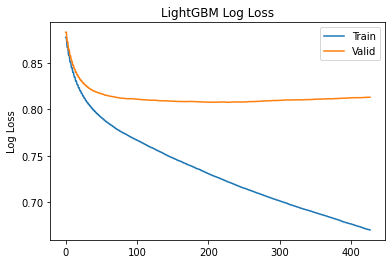

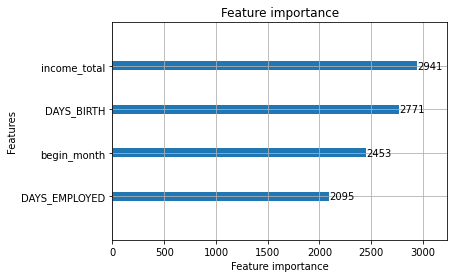

In [ ]:
label_cols = [ 'begin_month']
numerical_cols =['income_total','DAYS_BIRTH', 'DAYS_EMPLOYED', ]
df14_train, df14_test,logloss=make_dup_temp(label_cols,numerical_cols)
df_logloss.update({'df_14': logloss})

[1]	training's multi_logloss: 0.877094	training's multi_logloss: 0.877094	valid_1's multi_logloss: 0.882792	valid_1's multi_logloss: 0.882792
Training until validation scores don't improve for 100 rounds.
[2]	training's multi_logloss: 0.86648	training's multi_logloss: 0.86648	valid_1's multi_logloss: 0.872264	valid_1's multi_logloss: 0.872264
[3]	training's multi_logloss: 0.857802	training's multi_logloss: 0.857802	valid_1's multi_logloss: 0.863855	valid_1's multi_logloss: 0.863855
[4]	training's multi_logloss: 0.850499	training's multi_logloss: 0.850499	valid_1's multi_logloss: 0.856933	valid_1's multi_logloss: 0.856933
[5]	training's multi_logloss: 0.844038	training's multi_logloss: 0.844038	valid_1's multi_logloss: 0.851277	valid_1's multi_logloss: 0.851277
[6]	training's multi_logloss: 0.838613	training's multi_logloss: 0.838613	valid_1's multi_logloss: 0.846475	valid_1's multi_logloss: 0.846475
[7]	training's multi_logloss: 0.833845	training's multi_logloss: 0.833845	valid_1's mul

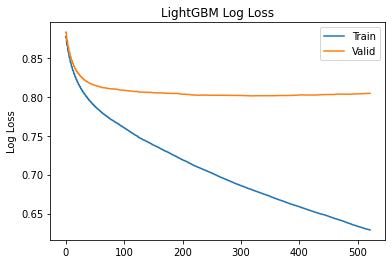

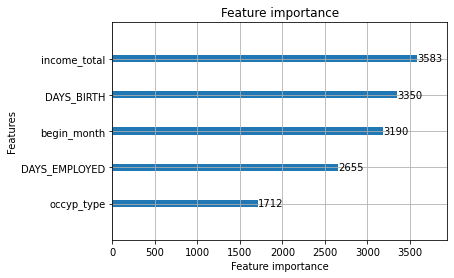

In [ ]:
label_cols = ['occyp_type',]
#onehot_cols = ['gender','car','reality',]
numerical_cols =['income_total',  'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']
df16_train, df16_test,logloss=make_dup_temp(label_cols,numerical_cols)
df_logloss.update({'df_16': logloss})

      edu_type  child_num
0            4          0
1            1          0
2            4          0
3            4          0
4            1          0
...        ...        ...
9995         2          0
9996         4          0
9997         4          0
9998         4          0
9999         1          0

[10000 rows x 2 columns]
[1]	training's multi_logloss: 0.877813	training's multi_logloss: 0.877813	valid_1's multi_logloss: 0.883159	valid_1's multi_logloss: 0.883159
Training until validation scores don't improve for 10 rounds.
[2]	training's multi_logloss: 0.867727	training's multi_logloss: 0.867727	valid_1's multi_logloss: 0.872888	valid_1's multi_logloss: 0.872888
[3]	training's multi_logloss: 0.859458	training's multi_logloss: 0.859458	valid_1's multi_logloss: 0.864727	valid_1's multi_logloss: 0.864727
[4]	training's multi_logloss: 0.852635	training's multi_logloss: 0.852635	valid_1's multi_logloss: 0.857995	valid_1's multi_logloss: 0.857995
[5]	training's multi_logloss: 0.

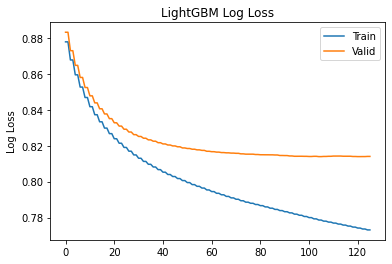

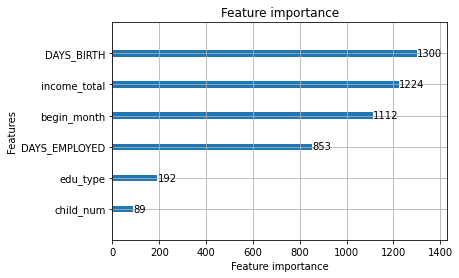

In [ ]:
label_cols = ['edu_type', 'child_num', ]
#onehot_cols = ['gender','car','reality',]
numerical_cols =['income_total','DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']
t_df12_train,t_df12_test,logloss=tun_make_dup_temp(label_cols,numerical_cols)
df_logloss.update({'t_df_12': logloss})

In [ ]:
t_df12_train

,income_total,DAYS_BIRTH,DAYS_EMPLOYED,begin_month,edu_type,child_num,credit
0,12.218495,38.0,13.0,6.0,1,0,1.0
1,12.419166,31.0,5.0,5.0,4,1,1.0
2,13.017003,52.0,13.0,22.0,1,0,2.0
3,12.218495,41.0,6.0,37.0,4,0,0.0
4,11.967181,41.0,6.0,26.0,1,0,2.0
...,...,...,...,...,...,...,...
23287,12.323856,33.0,6.0,2.0,4,1,1.0
23288,12.100712,42.0,7.0,47.0,1,1,2.0
23289,12.586220,28.0,6.0,25.0,4,0,2.0
23290,12.049419,28.0,1.0,59.0,2,0,2.0


## 불균형 데이터 처리 


In [ ]:

import warnings
warnings.filterwarnings("ignore")

In [ ]:

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

In [ ]:
def Data_imbalnce(train):
    index_imbalnce=['SMOTE','TomekLinks','SMOTEENN','SMOTETomek']
    list_logloss=pd.Series(index=index_imbalnce)
    y= train.loc[:,TARGET]
    X= train.drop(TARGET,axis=1)
    
    #smote
    X_samp, y_samp = SMOTE(random_state=4).fit_resample(X, y)
    X_train, X_valid, y_train, y_valid = train_test_split(X_samp, y_samp,test_size=0.25, random_state=21)
    
    lgbm_model=lgb.LGBMClassifier(objective='multiclass').fit(X_train, y_train)
    y_pred=lgbm_model.predict_proba(X_valid)
    list_logloss['SMOTE']=log_loss(to_categorical(y_valid), y_pred)
    
    #토맥
    X_samp, y_samp = TomekLinks().fit_resample(X, y)
    X_train, X_valid, y_train, y_valid = train_test_split(X_samp, y_samp,test_size=0.25, random_state=21)
    
    lgbm_model=lgb.LGBMClassifier(objective='multiclass').fit(X_train, y_train)
    y_pred=lgbm_model.predict_proba(X_valid)
    list_logloss['TomekLinks']=log_loss(to_categorical(y_valid), y_pred)
    
    # 스모틴
    X_samp, y_samp = SMOTEENN(random_state=4).fit_resample(X, y)
    X_train, X_valid, y_train, y_valid = train_test_split(X_samp, y_samp,test_size=0.25, random_state=21)
    
    lgbm_model=lgb.LGBMClassifier(objective='multiclass').fit(X_train, y_train)
    y_pred=lgbm_model.predict_proba(X_valid)
    list_logloss['SMOTEENN']=log_loss(to_categorical(y_valid), y_pred)
    
    #스모토멕
    X_samp, y_samp = SMOTETomek(random_state=4).fit_resample(X, y)
    X_train, X_valid, y_train, y_valid = train_test_split(X_samp, y_samp,test_size=0.25, random_state=21)
    
    lgbm_model=lgb.LGBMClassifier(objective='multiclass').fit(X_train, y_train)
    y_pred=lgbm_model.predict_proba(X_valid)
    list_logloss['SMOTETomek']=log_loss(to_categorical(y_valid), y_pred)
    
    return list_logloss
    
    

In [ ]:
def tun_Data_imbalnce(train):
    index_imbalnce=['SMOTE','TomekLinks','SMOTEENN','SMOTETomek']
    list_logloss=pd.Series(index=index_imbalnce)
    y= train.loc[:,TARGET]
    X= train.drop(TARGET,axis=1)
    



    #smote
    X_samp, y_samp = SMOTE(random_state=4).fit_resample(X, y)

    log_loss=Some_lightGBM(X_samp,y_samp)

    list_logloss['SMOTE']=log_loss
    
    #토맥
    X_samp, y_samp = TomekLinks().fit_resample(X, y)
    log_loss=Some_lightGBM(X_samp,y_samp)

    list_logloss['TomekLinks']=log_loss


    # 스모틴
    X_samp, y_samp = SMOTEENN(random_state=4).fit_resample(X, y)
    log_loss=Some_lightGBM(X_samp,y_samp)
    list_logloss['SMOTEENN']=log_loss
    
    #스모토멕
    X_samp, y_samp = SMOTETomek(random_state=4).fit_resample(X, y)
    log_loss=Some_lightGBM(X_samp,y_samp)

    list_logloss['SMOTETomek']=log_loss
    
    return list_logloss
    
    

In [ ]:
print("before logloss : ",df_logloss['df_1'])
temp_imbal=Data_imbalnce(df1_train) #변수 다넣은거
print(temp_imbal)

before logloss :  0.7246931865008024
SMOTE         0.727801
TomekLinks    0.746556
SMOTEENN      0.574922
SMOTETomek    0.692140
dtype: float64


In [ ]:
print("before logloss : ",df_logloss['df_2'])
df2_imbal=Data_imbalnce(df2_train) #변수 삭제
print(df2_imbal)
    

before logloss :  0.7477950393728944
SMOTE         0.748251
TomekLinks    0.750261
SMOTEENN      0.605487
SMOTETomek    0.717904
dtype: float64


In [ ]:
print("before logloss : ",df_logloss['df_17'])
df17_imbal=Data_dup_imbalnce(df17_train) # 데이터 불균형 처리
print(df17_imbal)


before logloss :  0.7835627354036774
SMOTE         0.781873
TomekLinks    0.767114
SMOTEENN      0.677705
SMOTETomek    0.784701
dtype: float64


In [ ]:
# print("before logloss : ",df_logloss['df_7'])
# df7_imbal=Data_dup_imbalnce(df7_train) # 데이터 불균형 처리
# print(df7_imbal)

KeyError: ignored

before logloss :  0.813931972326401
[1]	training's multi_logloss: 1.07624	training's multi_logloss: 1.07624	valid_1's multi_logloss: 1.07702	valid_1's multi_logloss: 1.07702
Training until validation scores don't improve for 10 rounds.
[2]	training's multi_logloss: 1.05726	training's multi_logloss: 1.05726	valid_1's multi_logloss: 1.05861	valid_1's multi_logloss: 1.05861
[3]	training's multi_logloss: 1.04023	training's multi_logloss: 1.04023	valid_1's multi_logloss: 1.04217	valid_1's multi_logloss: 1.04217
[4]	training's multi_logloss: 1.02492	training's multi_logloss: 1.02492	valid_1's multi_logloss: 1.02742	valid_1's multi_logloss: 1.02742
[5]	training's multi_logloss: 1.01164	training's multi_logloss: 1.01164	valid_1's multi_logloss: 1.01473	valid_1's multi_logloss: 1.01473
[6]	training's multi_logloss: 1	training's multi_logloss: 1	valid_1's multi_logloss: 1.00349	valid_1's multi_logloss: 1.00349
[7]	training's multi_logloss: 0.989338	training's multi_logloss: 0.989338	valid_1's mu

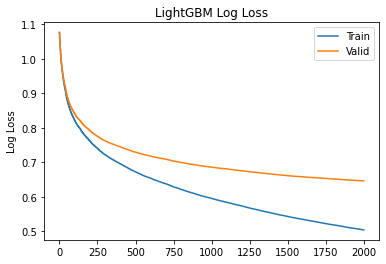


[1]	training's multi_logloss: 0.874663	training's multi_logloss: 0.874663	valid_1's multi_logloss: 0.865198	valid_1's multi_logloss: 0.865198
Training until validation scores don't improve for 10 rounds.
[2]	training's multi_logloss: 0.862076	training's multi_logloss: 0.862076	valid_1's multi_logloss: 0.854429	valid_1's multi_logloss: 0.854429
[3]	training's multi_logloss: 0.851578	training's multi_logloss: 0.851578	valid_1's multi_logloss: 0.845645	valid_1's multi_logloss: 0.845645
[4]	training's multi_logloss: 0.842935	training's multi_logloss: 0.842935	valid_1's multi_logloss: 0.838447	valid_1's multi_logloss: 0.838447
[5]	training's multi_logloss: 0.835557	training's multi_logloss: 0.835557	valid_1's multi_logloss: 0.832509	valid_1's multi_logloss: 0.832509
[6]	training's multi_logloss: 0.829185	training's multi_logloss: 0.829185	valid_1's multi_logloss: 0.827644	valid_1's multi_logloss: 0.827644
[7]	training's multi_logloss: 0.823552	training's multi_logloss: 0.823552	valid_1's m

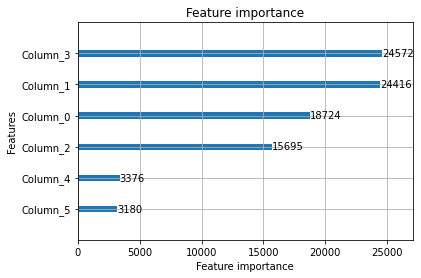

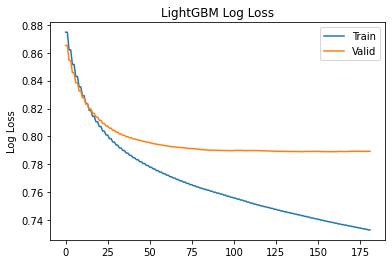


[1]	training's multi_logloss: 0.993706	training's multi_logloss: 0.993706	valid_1's multi_logloss: 1.00252	valid_1's multi_logloss: 1.00252
Training until validation scores don't improve for 10 rounds.
[2]	training's multi_logloss: 0.975686	training's multi_logloss: 0.975686	valid_1's multi_logloss: 0.985942	valid_1's multi_logloss: 0.985942
[3]	training's multi_logloss: 0.959772	training's multi_logloss: 0.959772	valid_1's multi_logloss: 0.971554	valid_1's multi_logloss: 0.971554
[4]	training's multi_logloss: 0.945849	training's multi_logloss: 0.945849	valid_1's multi_logloss: 0.958711	valid_1's multi_logloss: 0.958711
[5]	training's multi_logloss: 0.93321	training's multi_logloss: 0.93321	valid_1's multi_logloss: 0.946941	valid_1's multi_logloss: 0.946941
[6]	training's multi_logloss: 0.921697	training's multi_logloss: 0.921697	valid_1's multi_logloss: 0.936405	valid_1's multi_logloss: 0.936405
[7]	training's multi_logloss: 0.911201	training's multi_logloss: 0.911201	valid_1's multi

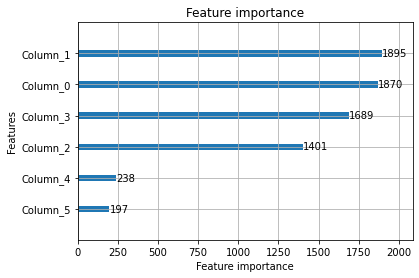

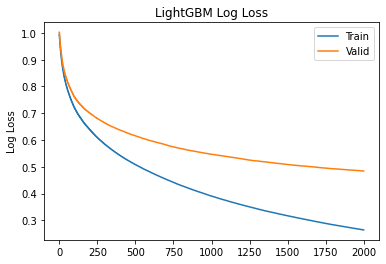


[1]	training's multi_logloss: 1.07543	training's multi_logloss: 1.07543	valid_1's multi_logloss: 1.07563	valid_1's multi_logloss: 1.07563
Training until validation scores don't improve for 10 rounds.
[2]	training's multi_logloss: 1.05562	training's multi_logloss: 1.05562	valid_1's multi_logloss: 1.05586	valid_1's multi_logloss: 1.05586
[3]	training's multi_logloss: 1.03859	training's multi_logloss: 1.03859	valid_1's multi_logloss: 1.03887	valid_1's multi_logloss: 1.03887
[4]	training's multi_logloss: 1.02371	training's multi_logloss: 1.02371	valid_1's multi_logloss: 1.02434	valid_1's multi_logloss: 1.02434
[5]	training's multi_logloss: 1.01037	training's multi_logloss: 1.01037	valid_1's multi_logloss: 1.01144	valid_1's multi_logloss: 1.01144
[6]	training's multi_logloss: 0.998282	training's multi_logloss: 0.998282	valid_1's multi_logloss: 0.999537	valid_1's multi_logloss: 0.999537
[7]	training's multi_logloss: 0.987946	training's multi_logloss: 0.987946	valid_1's multi_logloss: 0.9895

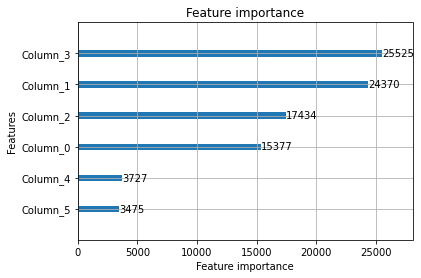

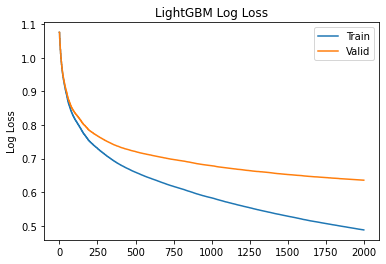


SMOTE         0.645755
TomekLinks    0.789078
SMOTEENN      0.484206
SMOTETomek    0.635921
dtype: float64


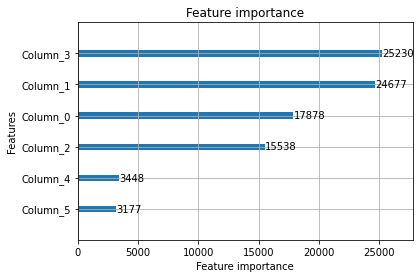

In [ ]:
print("before logloss : ",df_logloss['t_df_12'])
t_df12_imbal=tun_Data_imbalnce(t_df12_train) # 튜닝 중복데이터 삭제 
print(t_df12_imbal)


In [ ]:
print("before logloss : ",df_logloss['df_8'])
df8_imbal=Data_imbalnce(df8_train) # 데이터 중복 처리
print(df8_imbal)

In [ ]:
print("before logloss : ",df_logloss['df_9'])
df9_imbal=Data_imbalnce(df9_train)
print(df9_imbal)

In [ ]:
print("before logloss : ",df_logloss['df_10'])
df10_imbal=Data_imbalnce(df10_train)
print(df10_imbal)

In [ ]:
print("before logloss : ",df_logloss['df_11'])
df11_imbal=Data_imbalnce(df11_train)
print(df11_imbal)

In [ ]:
print("before logloss : ",df_logloss['df_12'])
df12_imbal=Data_imbalnce(df12_train)
print(df12_imbal)

In [ ]:
print("before logloss : ",df_logloss['df_13'])
df13_imbal=Data_imbalnce(df13_train)
print(df13_imbal)

In [ ]:
print("before logloss : ",df_logloss['df_14'])
df14_imbal=Data_imbalnce(df14_train)
print(df14_imbal)

In [ ]:
print("before logloss : ",df_logloss['df_15'])
df15_imbal=Data_imbalnce(df15_train)
print(df15_imbal)

In [ ]:
df16_imbal=Data_imbalnce(df16_train)
print(df16_imbal)

In [ ]:
print(df_logloss)

## k-fold 

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

In [ ]:

def run_kfold(clf,train,test_x):
    folds=StratifiedKFold(n_splits=7, shuffle=True, random_state=55)
    outcomes=[]


    
    sub=np.zeros((test_x.shape[0], 3))  
    train_y= train.loc[:,TARGET]
    train_x= train.drop(TARGET,axis=1)

    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        clf.fit(X_train, y_train)
        
        predictions=clf.predict_proba(X_val)
        #print(y_val)
        logloss=log_loss(to_categorical(y_val), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits



In [ ]:

def run_smotenn_kfold(clf,train,test_x):
    folds=StratifiedKFold(n_splits=7, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    train_y= train.loc[:,TARGET]
    train_x= train.drop(TARGET,axis=1)
    X_samp, y_samp = SMOTEENN(random_state=4).fit_resample(train_x, train_y)
    train_x=pd.DataFrame(X_samp)
    train_y=pd.DataFrame(y_samp)
    
    #X_train, X_valid, y_train, y_valid = train_test_split(X_samp, y_samp,test_size=0.25, random_state=21)

    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        clf.fit(X_train, y_train)
        
        predictions=clf.predict_proba(X_val)
        #print(y_val)
        logloss=log_loss(to_categorical(y_val), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits


In [ ]:
train_y_1= df9_train.loc[:,TARGET]
train_x_1= df9_train.drop(TARGET,axis=1)

X_samp, y_samp = SMOTEENN(random_state=4).fit_resample(train_x_1, train_y_1)
X_train, X_valid, y_train, y_valid = train_test_split(X_samp, y_samp,test_size=0.25, random_state=21)

lgbm_model_1=lgb.LGBMClassifier(objective='multiclass').fit(X_train, y_train)
#y_pred=lgbm_model.predict_proba(X_valid)
#list_logloss['SMOTEENN']=log_loss(to_categorical(y_valid), y_pred)

In [ ]:
train_y_2= t_df12_train.loc[:,TARGET]
train_x_2= t_df12_train.drop(TARGET,axis=1)

X_samp, y_samp = SMOTEENN(random_state=4).fit_resample(train_x_2, train_y_2)
X_train, X_valid, y_train, y_valid = train_test_split(X_samp, y_samp,test_size=0.25, random_state=21)
eval_set = [(X_train, y_train), (X_valid, y_valid)]
lgbm_model=lgb.LGBMClassifier(objective='multiclass',n_estimators=1000,max_depth=20,min_data_in_leaf=300)
lgbm_model.fit(X_train, y_train,early_stopping_rounds=20, eval_metric='logloss',eval_set=eval_set, verbose=True)


[1]	training's multi_logloss: 0.993706	training's multi_logloss: 0.993706	valid_1's multi_logloss: 1.00252	valid_1's multi_logloss: 1.00252
Training until validation scores don't improve for 20 rounds.
[2]	training's multi_logloss: 0.975686	training's multi_logloss: 0.975686	valid_1's multi_logloss: 0.985942	valid_1's multi_logloss: 0.985942
[3]	training's multi_logloss: 0.959772	training's multi_logloss: 0.959772	valid_1's multi_logloss: 0.971554	valid_1's multi_logloss: 0.971554
[4]	training's multi_logloss: 0.945849	training's multi_logloss: 0.945849	valid_1's multi_logloss: 0.958711	valid_1's multi_logloss: 0.958711
[5]	training's multi_logloss: 0.93321	training's multi_logloss: 0.93321	valid_1's multi_logloss: 0.946941	valid_1's multi_logloss: 0.946941
[6]	training's multi_logloss: 0.921697	training's multi_logloss: 0.921697	valid_1's multi_logloss: 0.936405	valid_1's multi_logloss: 0.936405
[7]	training's multi_logloss: 0.911201	training's multi_logloss: 0.911201	valid_1's multi_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=20,
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=300, min_split_gain=0.0, n_estimators=1000,
               n_jobs=-1, num_leaves=31, objective='multiclass',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# train_y_1= df9_train.loc[:,TARGET]
# train_x_1= df9_train.drop(TARGET,axis=1)
# lgbm_model_1=lgb.LGBMClassifier(objective='multiclass').fit(train_x_1, train_y_1)

In [ ]:
train_y_3= df17_train.loc[:,TARGET]
train_x_3= df17_train.drop(TARGET,axis=1)

X_samp, y_samp = SMOTEENN(random_state=4).fit_resample(train_x_3, train_y_3)
X_train, X_valid, y_train, y_valid = train_test_split(X_samp, y_samp,test_size=0.25, random_state=21)
eval_set = [(X_train, y_train), (X_valid, y_valid)]
lgbm_model=lgb.LGBMClassifier(objective='multiclass',n_estimators=1000,max_depth=20,min_data_in_leaf=300)
lgbm_model.fit(X_train, y_train,early_stopping_rounds=20, eval_metric='logloss',eval_set=eval_set, verbose=True)

[1]	training's multi_logloss: 1.01137	training's multi_logloss: 1.01137	valid_1's multi_logloss: 1.01574	valid_1's multi_logloss: 1.01574
Training until validation scores don't improve for 20 rounds.
[2]	training's multi_logloss: 0.994778	training's multi_logloss: 0.994778	valid_1's multi_logloss: 1.00037	valid_1's multi_logloss: 1.00037
[3]	training's multi_logloss: 0.979335	training's multi_logloss: 0.979335	valid_1's multi_logloss: 0.985851	valid_1's multi_logloss: 0.985851
[4]	training's multi_logloss: 0.966084	training's multi_logloss: 0.966084	valid_1's multi_logloss: 0.973725	valid_1's multi_logloss: 0.973725
[5]	training's multi_logloss: 0.954271	training's multi_logloss: 0.954271	valid_1's multi_logloss: 0.962753	valid_1's multi_logloss: 0.962753
[6]	training's multi_logloss: 0.943392	training's multi_logloss: 0.943392	valid_1's multi_logloss: 0.953027	valid_1's multi_logloss: 0.953027
[7]	training's multi_logloss: 0.933574	training's multi_logloss: 0.933574	valid_1's multi_lo

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=20,
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=300, min_split_gain=0.0, n_estimators=1000,
               n_jobs=-1, num_leaves=31, objective='multiclass',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
temp_kfold=run_smotenn_kfold(lgbm_model_1,df9_train,df9_test)

In [ ]:
temp_kfold=run_smotenn_kfold(lgbm_model_1,df11_train,df11_test)

In [ ]:
df12_kfold=run_smotenn_kfold(lgbm_model,t_df12_train,t_df12_test)

FOLD 0 : logloss:0.4731620510146397
FOLD 1 : logloss:0.469443130350168
FOLD 2 : logloss:0.4709280475646081
FOLD 3 : logloss:0.4835249541461582
FOLD 4 : logloss:0.46992042359665726
FOLD 5 : logloss:0.47939493576983316
FOLD 6 : logloss:0.4562610729709788
Mean:0.47180494505900616


In [ ]:
df17_kfold=run_smotenn_kfold(lgbm_model,df17_train,df17_test)

FOLD 0 : logloss:0.4879542007871625
FOLD 1 : logloss:0.4771229418439746
FOLD 2 : logloss:0.47527527627024063
FOLD 3 : logloss:0.4815849344796734
FOLD 4 : logloss:0.47752499781587954
FOLD 5 : logloss:0.46436078751098214
FOLD 6 : logloss:0.47646308028511186
Mean:0.47718374557043214


In [ ]:
df17_submission=copy.deepcopy(submission)
df17_submission.loc[:,1:]=df17_kfold
print(df17_submission)


      index         0         1         2
0     26457  0.104950  0.109495  0.785556
1     26458  0.012746  0.012926  0.974327
2     26459  0.263480  0.203231  0.533289
3     26460  0.387831  0.123495  0.488675
4     26461  0.181850  0.326519  0.491631
...     ...       ...       ...       ...
9995  36452  0.471742  0.104320  0.423938
9996  36453  0.217679  0.342750  0.439571
9997  36454  0.078916  0.019692  0.901392
9998  36455  0.211240  0.659382  0.129377
9999  36456  0.114466  0.565700  0.319833

[10000 rows x 4 columns]


In [ ]:
df17_submission.to_csv('manydeleteFeature_submission.csv', index=False)

SMOTEEN 을 한결과, 매우 높게 나왔다.

In [ ]:
dup_tun_submission=copy.deepcopy(submission)

In [ ]:
len(df12_kfold)

10000

In [ ]:
dup_tun_submission.loc[:,1:]=df12_kfold

In [ ]:
dup_tun_submission.to_csv('dup_tun_submission.csv', index=False)

중복 처리+SMOTEEEN을 한 결과, 1.2 로 굉장히 높게 나왔다.

In [ ]:
# train_y_1= df15_train.loc[:,TARGET]
# train_x_1= df15_train.drop(TARGET,axis=1)

# X_samp, y_samp = SMOTEENN(random_state=4).fit_resample(train_x_1, train_y_1)
# X_train, X_valid, y_train, y_valid = train_test_split(X_samp, y_samp,test_size=0.25, random_state=21)

# lgbm_model_2=lgb.LGBMClassifier(objective='multiclass').fit(X_train, y_train)

In [ ]:
temp_kfold=run_smotenn_kfold(lgbm_model_2,df15_train,df15_test)

FOLD 0 : logloss:0.6376545868249547
FOLD 1 : logloss:0.6397181498038689
FOLD 2 : logloss:0.6234547075899407
FOLD 3 : logloss:0.6322059551749785
FOLD 4 : logloss:0.6358335874747034
FOLD 5 : logloss:0.6323055065000251
FOLD 6 : logloss:0.6399387426369257
Mean:0.6344444622864852


In [ ]:
temp_X_sampe=pd.DataFrame(X_samp)
print(temp_X_sampe)

         0    1     2     3    4    5    6   ...   10   11   12   13   14    15   16
0      27.0  2.0  41.0  15.0  4.0  1.0  0.0  ...  1.0  0.0  0.0  0.0  1.0   4.0  0.0
1      16.0  3.0  33.0   6.0  5.0  0.0  1.0  ...  1.0  0.0  0.0  0.0  0.0   0.0  1.0
2      16.0  4.0  35.0  12.0  5.0  1.0  1.0  ...  5.0  0.0  1.0  4.0  0.0   4.0  1.0
3      16.0  2.0  42.0   4.0  2.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  0.0   8.0  0.0
4      12.0  2.0  33.0   5.0  2.0  0.0  0.0  ...  0.0  0.0  1.0  0.0  0.0  14.0  0.0
...     ...  ...   ...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...
28212  22.0  1.0  30.0   1.0  2.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  0.0   1.0  0.0
28213   7.0  2.0  53.0   0.0  5.0  0.0  0.0  ...  1.0  0.0  0.0  1.0  0.0  18.0  0.0
28214   9.0  1.0  66.0   0.0  4.0  0.0  0.0  ...  1.0  0.0  0.0  1.0  0.0  18.0  0.0
28215  14.0  2.0  45.0  27.0  3.0  0.0  0.0  ...  1.0  0.0  0.0  4.0  1.0  10.0  0.0
28216  29.0  2.0  28.0   6.0  2.0  0.0  1.0  ...  5.0  0.0  0.0  

In [ ]:
submission_temp=run_kfold(lgbm_model_1,df9_train,df9_test)

FOLD 0 : logloss:0.8031317867783607
FOLD 1 : logloss:0.7912282355333903
FOLD 2 : logloss:0.8001070428858068
FOLD 3 : logloss:0.7941604971596027
FOLD 4 : logloss:0.7875542531972001
FOLD 5 : logloss:0.7994894577264792
FOLD 6 : logloss:0.7877823225876078
Mean:0.794779085124064
